# Notebook TFM

## Carga de datos

In [2]:
import pandas as pd
import os
import matplotlib as plt
import numpy as np

In [3]:
dir = './Hangzhou-mobility-data-set'
archivos_csv = [archivo for archivo in os.listdir(dir) if archivo.startswith('record') and archivo.endswith('.csv')]
dataframes = [pd.read_csv(os.path.join(dir, archivo)) for archivo in archivos_csv]
records = pd.concat(dataframes, ignore_index=True)
est = pd.read_csv('./Hangzhou-mobility-data-set/Metro_roadMap.csv')
meteo = pd.read_csv('./Hangzhou-mobility-data-set/HangzhouMeteoData.csv')

In [4]:
records['time'] = pd.to_datetime(records['time'])

In [5]:
records

,time,lineID,stationID,deviceID,status,userID,payType
0,2019-01-01 02:00:05,B,27,1354,0,D13f76f42c9a677c4add94d9e480fb5c5,3
1,2019-01-01 02:01:40,B,5,200,1,D9a337d37d9512184b8e3fd477934b293,3
2,2019-01-01 02:01:53,B,5,247,0,Dc9e179298617f40b782490c1f3e2346c,3
3,2019-01-01 02:02:38,B,5,235,0,D9a337d37d9512184b8e3fd477934b293,3
4,2019-01-01 02:03:42,B,23,1198,0,Dd1cde61886c23fdb7ef1fdb76c9b1234,3
...,...,...,...,...,...,...,...
58637232,2019-01-25 23:59:50,B,25,1270,0,C6b29c306dbc433f41950282ac723bd69,2
58637233,2019-01-25 23:59:51,C,59,2782,0,B6d0780ed4b6a38441c675a0d3dbfabf3,1
58637234,2019-01-25 23:59:51,B,25,1267,0,A1e34c36ef8ad13266b53b288162d49aa,0
58637235,2019-01-25 23:59:52,C,63,2934,0,Bcf799101b0151ffe0e65c7c7f3844b9e,1


In [6]:
est

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,71,72,73,74,75,76,77,78,79,80
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,76,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
77,77,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
78,78,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
79,79,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [7]:
meteo

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,"Hangzhou ,Zhejiang ,China",2019-01-01T00:00:00,3.0,1.0,0.0,80.66,0.0,0,NaN,NaN,...,1038.0,89.0,7.0,0.0,0.0,0,NaN,Partially cloudy,partly-cloudy-night,"58457099999,ZSHC"
1,"Hangzhou ,Zhejiang ,China",2019-01-01T01:00:00,3.0,1.0,1.0,86.70,0.0,0,NaN,NaN,...,1038.0,89.0,6.0,0.0,0.0,0,NaN,Partially cloudy,partly-cloudy-night,"58457099999,ZSHC"
2,"Hangzhou ,Zhejiang ,China",2019-01-01T02:00:00,2.3,0.9,0.5,88.21,0.0,0,NaN,NaN,...,1039.2,88.0,6.0,0.0,0.0,0,NaN,Partially cloudy,partly-cloudy-night,"58457099999,ZSHC"
3,"Hangzhou ,Zhejiang ,China",2019-01-01T03:00:00,3.0,1.0,0.0,80.66,0.0,0,NaN,NaN,...,1038.0,89.0,6.0,0.0,0.0,0,NaN,Partially cloudy,partly-cloudy-night,"58457099999,ZSHC"
4,"Hangzhou ,Zhejiang ,China",2019-01-01T04:00:00,3.0,1.0,0.0,80.66,0.0,0,NaN,NaN,...,1038.0,89.0,6.0,0.0,0.0,0,NaN,Partially cloudy,partly-cloudy-night,"58457099999,ZSHC"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,"Hangzhou ,Zhejiang ,China",2019-01-25T19:00:00,10.0,10.0,4.0,66.29,0.0,0,NaN,NaN,...,1029.0,50.0,5.0,0.0,0.0,0,NaN,Partially cloudy,partly-cloudy-night,"58457099999,ZSHC"
596,"Hangzhou ,Zhejiang ,China",2019-01-25T20:00:00,9.1,7.1,3.3,67.25,0.0,0,NaN,NaN,...,1030.9,25.0,7.5,0.0,0.0,0,NaN,Partially cloudy,partly-cloudy-night,"58457099999,ZSHC"
597,"Hangzhou ,Zhejiang ,China",2019-01-25T21:00:00,8.0,5.5,3.0,70.70,0.0,0,NaN,NaN,...,1031.0,50.0,6.0,0.0,0.0,0,NaN,Partially cloudy,partly-cloudy-night,"58457099999,ZSHC"
598,"Hangzhou ,Zhejiang ,China",2019-01-25T22:00:00,8.0,4.7,2.0,65.85,0.0,0,NaN,NaN,...,1032.0,50.0,6.0,0.0,0.0,0,NaN,Partially cloudy,partly-cloudy-night,"58457099999,ZSHC"


In [8]:
meteo.columns

Index(['name', 'datetime', 'temp', 'feelslike', 'dew', 'humidity', 'precip',
       'precipprob', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'conditions',
       'icon', 'stations'],
      dtype='object')

In [9]:
lala = meteo[(meteo['icon'].notna()) & meteo['icon']!=0]
lala['icon']

0      partly-cloudy-night
1      partly-cloudy-night
2      partly-cloudy-night
3      partly-cloudy-night
4      partly-cloudy-night
              ...         
595    partly-cloudy-night
596    partly-cloudy-night
597    partly-cloudy-night
598    partly-cloudy-night
599    partly-cloudy-night
Name: icon, Length: 600, dtype: object

## Comprobación de nulos y tipos

In [10]:
#Valores nulos en los records

hay_nan = records.isna().any().any()
if hay_nan:
    print("El DataFrame contiene valores NaN.")
else:
    print("El DataFrame no contiene valores NaN.")

El DataFrame no contiene valores NaN.


In [11]:
#Valores nulos en las estaciones
hay_nan = est.isna().any().any()
if hay_nan:
    print("El DataFrame contiene valores NaN.")
else:
    print("El DataFrame no contiene valores NaN.")

El DataFrame no contiene valores NaN.


In [12]:
#Valores nulos en las estaciones
hay_nan = meteo.isna().any().any()
if hay_nan:
    print("El DataFrame contiene valores NaN.")
else:
    print("El DataFrame no contiene valores NaN.")

El DataFrame contiene valores NaN.


In [13]:
# Filtrar las columnas con valores nulos
columnas_con_nulos = meteo.columns[meteo.isnull().any()]

# Mostrar las columnas con valores nulos y la cantidad de valores nulos en cada una
for columna in columnas_con_nulos:
    cantidad_nulos = meteo[columna].isnull().sum()
    print(f'Columna "{columna}" tiene {cantidad_nulos} valores nulos.')

Columna "preciptype" tiene 567 valores nulos.
Columna "snow" tiene 600 valores nulos.
Columna "snowdepth" tiene 600 valores nulos.
Columna "windgust" tiene 599 valores nulos.
Columna "severerisk" tiene 600 valores nulos.


In [14]:
records.dtypes

time         datetime64[ns]
lineID               object
stationID             int64
deviceID              int64
status                int64
userID               object
payType               int64
dtype: object

In [15]:
records.dtypes

time         datetime64[ns]
lineID               object
stationID             int64
deviceID              int64
status                int64
userID               object
payType               int64
dtype: object

In [16]:
records

,time,lineID,stationID,deviceID,status,userID,payType
0,2019-01-01 02:00:05,B,27,1354,0,D13f76f42c9a677c4add94d9e480fb5c5,3
1,2019-01-01 02:01:40,B,5,200,1,D9a337d37d9512184b8e3fd477934b293,3
2,2019-01-01 02:01:53,B,5,247,0,Dc9e179298617f40b782490c1f3e2346c,3
3,2019-01-01 02:02:38,B,5,235,0,D9a337d37d9512184b8e3fd477934b293,3
4,2019-01-01 02:03:42,B,23,1198,0,Dd1cde61886c23fdb7ef1fdb76c9b1234,3
...,...,...,...,...,...,...,...
58637232,2019-01-25 23:59:50,B,25,1270,0,C6b29c306dbc433f41950282ac723bd69,2
58637233,2019-01-25 23:59:51,C,59,2782,0,B6d0780ed4b6a38441c675a0d3dbfabf3,1
58637234,2019-01-25 23:59:51,B,25,1267,0,A1e34c36ef8ad13266b53b288162d49aa,0
58637235,2019-01-25 23:59:52,C,63,2934,0,Bcf799101b0151ffe0e65c7c7f3844b9e,1


## Exploración de los datos

### Horas no completas

In [17]:
# Supongamos que tienes un DataFrame llamado records
# Crea un DataFrame con las columnas 'time', 'stationID' y 'day'
df_time_station_day = records[['time', 'stationID']]
df_time_station_day['day'] = df_time_station_day['time'].dt.date

# Extrae la hora de la columna 'time'
df_time_station_day['hour'] = df_time_station_day['time'].dt.hour

C:\Users\Usuario\AppData\Local\Temp\ipykernel_4912\1681229267.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_station_day['day'] = df_time_station_day['time'].dt.date
C:\Users\Usuario\AppData\Local\Temp\ipykernel_4912\1681229267.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_station_day['hour'] = df_time_station_day['time'].dt.hour


In [18]:
# Agrupa por día, hora y estación y cuenta las observaciones en cada grupo
daily_hourly_station_counts = df_time_station_day.groupby(['day', 'hour', 'stationID']).size().reset_index(name='count')
daily_hourly_station_counts

,day,hour,stationID,count
0,2019-01-01,2,3,1
1,2019-01-01,2,4,1
2,2019-01-01,2,5,7
3,2019-01-01,2,6,2
4,2019-01-01,2,14,2
...,...,...,...,...
41531,2019-01-25,23,76,35
41532,2019-01-25,23,77,91
41533,2019-01-25,23,78,225
41534,2019-01-25,23,79,59


In [19]:
# Obtiene la lista de todas las estaciones únicas
estaciones_unicas = df_time_station_day['stationID'].unique()
estaciones_unicas.sort()
estaciones_unicas

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80], dtype=int64)

In [20]:
hours = np.arange(24)
hours

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [21]:
daily_hourly_station_counts[(daily_hourly_station_counts['stationID'] == 4) & (daily_hourly_station_counts['hour'] == 16)].count()

day          25
hour         25
stationID    25
count        25
dtype: int64

In [22]:
#for hour in range(24):
hours_to_delete = []
est_and_hour = []
for hour in hours:
    for est in estaciones_unicas:
        if (daily_hourly_station_counts[(daily_hourly_station_counts['stationID'] == est) & (daily_hourly_station_counts['hour'] == hour)].count().iloc[0] != 25):# & hora not in hours_to_delete:
            hours_to_delete.append(hour)
            est_and_hour.append([est,hour])

In [23]:
len(est_and_hour)

395

In [24]:
hours_to_delete.sort()
unique_values = list(set(hours_to_delete))

# Print the unique values
print(unique_values)

[0, 1, 2, 3, 4, 5]


In [25]:
records = records.loc[~records['time'].dt.hour.isin(unique_values)]
records

,time,lineID,stationID,deviceID,status,userID,payType
3701,2019-01-01 06:00:00,B,15,759,1,Baecfa51276fa6f1e432963c4cb3f6a0f,1
3702,2019-01-01 06:00:00,B,32,1558,1,Da2260acda93095e55bf466b8993d58b5,3
3703,2019-01-01 06:00:01,B,8,402,1,Bb8e687d5aedc9040879b67952787c35d,1
3704,2019-01-01 06:00:02,B,32,1562,1,C03b90c5dfab9ac10a00e2fca9ac7aa11,2
3705,2019-01-01 06:00:02,B,9,446,0,Be9c9b52a7ae40b6c32ff4631854e1cfa,1
...,...,...,...,...,...,...,...
58637232,2019-01-25 23:59:50,B,25,1270,0,C6b29c306dbc433f41950282ac723bd69,2
58637233,2019-01-25 23:59:51,C,59,2782,0,B6d0780ed4b6a38441c675a0d3dbfabf3,1
58637234,2019-01-25 23:59:51,B,25,1267,0,A1e34c36ef8ad13266b53b288162d49aa,0
58637235,2019-01-25 23:59:52,C,63,2934,0,Bcf799101b0151ffe0e65c7c7f3844b9e,1


### Cálculo correlación

In [17]:
df_agrupado = records.set_index('time').drop(columns=['payType']).groupby([pd.Grouper(freq='H', level=0),'stationID', 'lineID','status'])['userID'].agg('count').reset_index()
df_agrupado

,time,stationID,lineID,status,userID
0,2019-01-01 06:00:00,0,B,0,123
1,2019-01-01 06:00:00,0,B,1,209
2,2019-01-01 06:00:00,1,B,0,77
3,2019-01-01 06:00:00,1,B,1,105
4,2019-01-01 06:00:00,2,B,0,154
...,...,...,...,...,...
71806,2019-01-25 23:00:00,78,A,1,88
71807,2019-01-25 23:00:00,79,A,0,49
71808,2019-01-25 23:00:00,79,A,1,10
71809,2019-01-25 23:00:00,80,A,0,61


In [18]:
# Definir un diccionario de mapeo de valores únicos en "lineID" a números
mapeo_lineID = {
    'A': 1,
    'B': 2,
    'C': 3,
    # Agrega más mapeos según sea necesario
}

# Aplicar la conversión utilizando el método map
df_agrupado['lineID'] = df_agrupado['lineID'].map(mapeo_lineID)
df_agrupado['lineID'] = df_agrupado['lineID'].astype('category')
df_agrupado.corr()

,time,stationID,lineID,status,userID
time,1.000000,0.000076,-0.000186,0.000329,0.020206
stationID,0.000076,1.000000,-0.110264,-0.000172,-0.264852
lineID,-0.000186,-0.110264,1.000000,0.000029,-0.016572
status,0.000329,-0.000172,0.000029,1.000000,0.001221
userID,0.020206,-0.264852,-0.016572,0.001221,1.000000


In [24]:
df_agrupado.corr()['userID']

time         0.020206
stationID   -0.264852
lineID      -0.016572
status       0.001221
userID       1.000000
Name: userID, dtype: float64

In [26]:
test_corr = df_agrupado[(df_agrupado['stationID']==10) & (df_agrupado['time'].dt.day==20)]
test_corr.corr()

,time,stationID,lineID,status,userID
time,1.000000e+00,NaN,NaN,-1.802072e-13,0.125763
stationID,NaN,NaN,NaN,NaN,NaN
lineID,NaN,NaN,NaN,NaN,NaN
status,-1.802072e-13,NaN,NaN,1.000000e+00,0.048275
userID,1.257632e-01,NaN,NaN,4.827479e-02,1.000000


In [23]:
test_corr

,time,stationID,lineID,status,userID
68934,2019-01-25 06:00:00,0,2,0,72
68935,2019-01-25 06:00:00,0,2,1,554
68936,2019-01-25 06:00:00,1,2,0,29
68937,2019-01-25 06:00:00,1,2,1,223
68938,2019-01-25 06:00:00,2,2,0,61
...,...,...,...,...,...
71806,2019-01-25 23:00:00,78,1,1,88
71807,2019-01-25 23:00:00,79,1,0,49
71808,2019-01-25 23:00:00,79,1,1,10
71809,2019-01-25 23:00:00,80,1,0,61


In [30]:
# Agrupar por la columna 'stationID' y contar los valores únicos en 'lineID'
stations_with_different_lines = df_agrupado.groupby('stationID')['lineID'].nunique()

# Filtrar las estaciones que tienen más de un valor único en 'lineID'
stations_with_multiple_lines = stations_with_different_lines[stations_with_different_lines > 1]
stations_with_multiple_lines

Series([], Name: lineID, dtype: int64)

### Valores atípicos

In [36]:
df_agrupado = records.set_index('time')
df_agrupado = df_agrupado.groupby(['stationID', df_agrupado.index.date, 'status'])['userID'].count().unstack(fill_value=0)
df_agrupado.rename(columns={0: 'salida', 1: 'entrada'}, inplace=True)
df_agrupado

status                salida  entrada
stationID                            
0         2019-01-01   10194    12526
          2019-01-02    9813    10893
          2019-01-03   10156    10669
          2019-01-04   10024    10306
          2019-01-05    8136     8237
...                      ...      ...
80        2019-01-21    4754     5336
          2019-01-22    4696     5318
          2019-01-23    4704     5361
          2019-01-24    4831     5508
          2019-01-25    4786     5464

[2000 rows x 2 columns]

In [37]:
df_agrupado.reset_index(inplace=True)
df_agrupado.rename(columns={"level_1": 'time'}, inplace=True)

In [38]:
df_agrupado

status,stationID,time,salida,entrada
0,0,2019-01-01,10194,12526
1,0,2019-01-02,9813,10893
2,0,2019-01-03,10156,10669
3,0,2019-01-04,10024,10306
4,0,2019-01-05,8136,8237
...,...,...,...,...
1995,80,2019-01-21,4754,5336
1996,80,2019-01-22,4696,5318
1997,80,2019-01-23,4704,5361
1998,80,2019-01-24,4831,5508


In [39]:
filas_estacion  = df_agrupado[df_agrupado['stationID'] == 15]
filas_estacion 

status,stationID,time,salida,entrada
375,15,2019-01-01,155886,200867
376,15,2019-01-02,86944,104371
377,15,2019-01-03,74135,77448
378,15,2019-01-04,92282,88379
379,15,2019-01-05,78058,80146
380,15,2019-01-06,86009,93158
381,15,2019-01-07,78488,77832
382,15,2019-01-08,76885,76051
383,15,2019-01-09,76404,79493
384,15,2019-01-10,81712,79968


<Axes: >

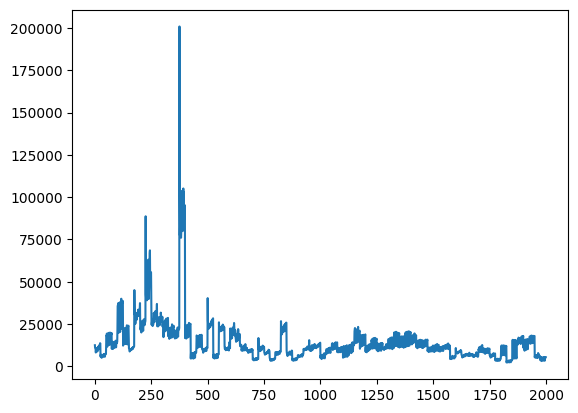

In [40]:
df_agrupado['entrada'].plot()

In [41]:
excepciones_entrada = df_agrupado[df_agrupado['entrada']>200000]
excepciones_entrada

status,stationID,time,salida,entrada
375,15,2019-01-01,155886,200867


<Axes: >

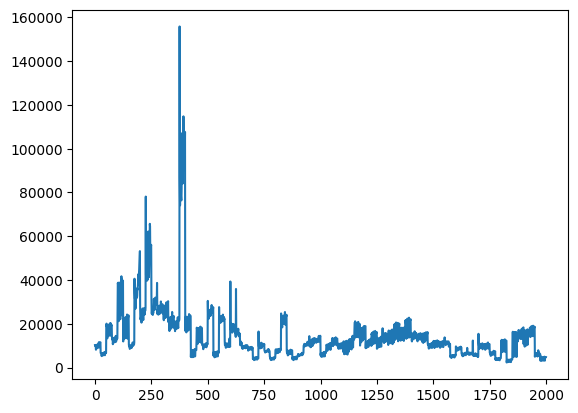

In [42]:
df_agrupado['salida'].plot()

In [43]:
excepciones_entrada = df_agrupado[df_agrupado['salida']>150000]
excepciones_entrada

status,stationID,time,salida,entrada
375,15,2019-01-01,155886,200867


### Agrupaciones varias

In [ ]:
df_agrupado = records.set_index('time')
df_agrupado = df_agrupado.groupby([pd.Grouper(freq='H', level=0),'stationID', 'lineID','payType','status'])['userID'].agg('count').reset_index()
df_agrupado

,time,stationID,lineID,payType,status,userID
0,2019-01-01 06:00:00,0,B,0,0,6
1,2019-01-01 06:00:00,0,B,0,1,18
2,2019-01-01 06:00:00,0,B,1,0,42
3,2019-01-01 06:00:00,0,B,1,1,39
4,2019-01-01 06:00:00,0,B,2,0,30
...,...,...,...,...,...,...
285456,2019-01-25 23:00:00,80,A,1,1,6
285457,2019-01-25 23:00:00,80,A,2,0,17
285458,2019-01-25 23:00:00,80,A,2,1,2
285459,2019-01-25 23:00:00,80,A,3,0,5


In [ ]:
df_agrupado = records.set_index('time')

In [ ]:
df_agrupado = df_agrupado.groupby(['stationID', df_agrupado.index.date, 'status'])['userID'].count().unstack(fill_value=0)
df_agrupado.rename(columns={0: 'salida', 1: 'entrada'}, inplace=True)

In [ ]:
records

,time,lineID,stationID,deviceID,status,userID,payType
3701,2019-01-01 06:00:00,B,15,759,1,Baecfa51276fa6f1e432963c4cb3f6a0f,1
3702,2019-01-01 06:00:00,B,32,1558,1,Da2260acda93095e55bf466b8993d58b5,3
3703,2019-01-01 06:00:01,B,8,402,1,Bb8e687d5aedc9040879b67952787c35d,1
3704,2019-01-01 06:00:02,B,32,1562,1,C03b90c5dfab9ac10a00e2fca9ac7aa11,2
3705,2019-01-01 06:00:02,B,9,446,0,Be9c9b52a7ae40b6c32ff4631854e1cfa,1
...,...,...,...,...,...,...,...
58637232,2019-01-25 23:59:50,B,25,1270,0,C6b29c306dbc433f41950282ac723bd69,2
58637233,2019-01-25 23:59:51,C,59,2782,0,B6d0780ed4b6a38441c675a0d3dbfabf3,1
58637234,2019-01-25 23:59:51,B,25,1267,0,A1e34c36ef8ad13266b53b288162d49aa,0
58637235,2019-01-25 23:59:52,C,63,2934,0,Bcf799101b0151ffe0e65c7c7f3844b9e,1


In [ ]:
'''records.set_index('time', inplace=True)
df_agrupado = records.set_index('time').groupby('stationID')
for estacion, datos in df_agrupado:
    print(f"Estación {estacion}:")
    print(datos)'''

'records.set_index(\'time\', inplace=True)\ndf_agrupado = records.set_index(\'time\').groupby(\'stationID\')\nfor estacion, datos in df_agrupado:\n    print(f"Estación {estacion}:")\n    print(datos)'

In [ ]:
'''resultados = pd.DataFrame()
for estacion, datos in df_agrupado:
    recuento_usuarios = datos['userID'].resample('10T').count()
    # Agregar los resultados al DataFrame de resultados
    resultados[f'Estacion_{estacion}'] = recuento_usuarios

resultados'''

"resultados = pd.DataFrame()\nfor estacion, datos in df_agrupado:\n    recuento_usuarios = datos['userID'].resample('10T').count()\n    # Agregar los resultados al DataFrame de resultados\n    resultados[f'Estacion_{estacion}'] = recuento_usuarios\n\nresultados"

In [ ]:
df_agrupado

status                salida  entrada
stationID                            
0         2019-01-01   10194    12526
          2019-01-02    9813    10893
          2019-01-03   10156    10669
          2019-01-04   10024    10306
          2019-01-05    8136     8237
...                      ...      ...
80        2019-01-21    4754     5336
          2019-01-22    4696     5318
          2019-01-23    4704     5361
          2019-01-24    4831     5508
          2019-01-25    4786     5464

[2000 rows x 2 columns]

In [ ]:
df_agrupado.reset_index(inplace=True)
df_agrupado

status,stationID,level_1,salida,entrada
0,0,2019-01-01,10194,12526
1,0,2019-01-02,9813,10893
2,0,2019-01-03,10156,10669
3,0,2019-01-04,10024,10306
4,0,2019-01-05,8136,8237
...,...,...,...,...
1995,80,2019-01-21,4754,5336
1996,80,2019-01-22,4696,5318
1997,80,2019-01-23,4704,5361
1998,80,2019-01-24,4831,5508


In [ ]:
#test_in_out = records.groupby(['stationID', records.index.date, records.index.hour, 'status'])['userID'].count().unstack(fill_value=0)
df_agrupado = records.set_index('time')
df_agrupado = df_agrupado.groupby(['stationID', df_agrupado.index, 'status'])['userID'].count().unstack(fill_value=0)
df_agrupado.rename(columns={0: 'salida', 1: 'entrada'}, inplace=True)
df_agrupado

status                         salida  entrada
stationID time                                
0         2019-01-01 06:01:40       0        2
          2019-01-01 06:01:41       0        1
          2019-01-01 06:03:51       0        1
          2019-01-01 06:03:56       0        1
          2019-01-01 06:04:09       0        1
...                               ...      ...
80        2019-01-25 23:48:05       1        0
          2019-01-25 23:49:11       1        0
          2019-01-25 23:54:29       1        0
          2019-01-25 23:54:33       1        0
          2019-01-25 23:56:58       1        0

[37559695 rows x 2 columns]

In [ ]:
df_agrupado = records.set_index('time')
df_agrupado = df_agrupado.groupby(['stationID', pd.Grouper(freq='H', level=0), 'status'])['userID'].count().unstack(fill_value=0)
df_agrupado.rename(columns={0: 'salida', 1: 'entrada'}, inplace=True)
df_agrupado

status                         salida  entrada
stationID time                                
0         2019-01-01 06:00:00     123      209
          2019-01-01 07:00:00     159      623
          2019-01-01 08:00:00     271      818
          2019-01-01 09:00:00     425     1035
          2019-01-01 10:00:00     562     1152
...                               ...      ...
80        2019-01-25 19:00:00     416      156
          2019-01-25 20:00:00     371      182
          2019-01-25 21:00:00     395      156
          2019-01-25 22:00:00     244      121
          2019-01-25 23:00:00      61       14

[36000 rows x 2 columns]

In [62]:
df_agrupado = records.set_index('time').drop(columns=['payType']).groupby([pd.Grouper(freq='H', level=0),'stationID', 'lineID','status'])['userID'].agg('count').reset_index()
# Definir un diccionario de mapeo de valores únicos en "lineID" a números
mapeo_lineID = {
    'A': 1,
    'B': 2,
    'C': 3,
    # Agrega más mapeos según sea necesario
}

# Aplicar la conversión utilizando el método map
df_agrupado['lineID'] = df_agrupado['lineID'].map(mapeo_lineID)
df_agrupado['lineID'] = df_agrupado['lineID'].astype('category')
df_agrupado

,time,stationID,lineID,status,userID
0,2019-01-01 06:00:00,0,2,0,123
1,2019-01-01 06:00:00,0,2,1,209
2,2019-01-01 06:00:00,1,2,0,77
3,2019-01-01 06:00:00,1,2,1,105
4,2019-01-01 06:00:00,2,2,0,154
...,...,...,...,...,...
71806,2019-01-25 23:00:00,78,1,1,88
71807,2019-01-25 23:00:00,79,1,0,49
71808,2019-01-25 23:00:00,79,1,1,10
71809,2019-01-25 23:00:00,80,1,0,61


In [75]:
df_agrupado = records.set_index('time')
#Para agrupar por horas poner 'H' en la frecuencia del Grouper
df_agrupado = df_agrupado.groupby(['stationID', pd.Grouper(freq='10T', level=0),'lineID' ,'status'])['userID'].count().unstack(fill_value=0)
df_agrupado.rename(columns={0: 'salida', 1: 'entrada'}, inplace=True)
df_agrupado.reset_index(inplace=True)
mapeo_lineID = {
    'A': 1,
    'B': 2,
    'C': 3,
    # Agrega más mapeos según sea necesario
}

# Aplicar la conversión utilizando el método map
df_agrupado['lineID'] = df_agrupado['lineID'].map(mapeo_lineID)
df_agrupado['lineID'] = df_agrupado['lineID'].astype('category')

In [80]:
df_agrupado.corr()

status,stationID,time,lineID,salida,entrada
status,,,,,
stationID,1.000000,-0.000011,-0.104700,-0.252677,-0.259337
time,-0.000011,1.000000,-0.000574,0.019125,0.017953
lineID,-0.104700,-0.000574,1.000000,-0.019976,-0.020386
salida,-0.252677,0.019125,-0.019976,1.000000,0.638046
entrada,-0.259337,0.017953,-0.020386,0.638046,1.000000


In [79]:
test_corr = df_agrupado[(df_agrupado['time'].dt.day==20)]
test_corr.corr()

status,stationID,time,lineID,salida,entrada
status,,,,,
stationID,1.000000,-0.003277,-0.104154,-0.303926,-0.304857
time,-0.003277,1.000000,0.009672,0.045218,-0.019932
lineID,-0.104154,0.009672,1.000000,-0.028633,-0.034632
salida,-0.303926,0.045218,-0.028633,1.000000,0.771910
entrada,-0.304857,-0.019932,-0.034632,0.771910,1.000000


In [76]:
df_agrupado

status,stationID,time,lineID,salida,entrada
0,0,2019-01-01 06:00:00,2,0,17
1,0,2019-01-01 06:10:00,2,0,21
2,0,2019-01-01 06:20:00,2,1,30
3,0,2019-01-01 06:30:00,2,49,44
4,0,2019-01-01 06:40:00,2,48,31
...,...,...,...,...,...
213886,80,2019-01-25 23:10:00,1,24,3
213887,80,2019-01-25 23:20:00,1,9,2
213888,80,2019-01-25 23:30:00,1,7,0
213889,80,2019-01-25 23:40:00,1,5,1


In [48]:
df_agrupado.dtypes

time         datetime64[ns]
stationID             int64
lineID             category
status                int64
userID                int64
entrada             float64
salida              float64
dtype: object

### Operaciones con dataset METEO

In [26]:
meteo.rename(columns={"datetime": 'time'}, inplace=True)
meteo['time'] = pd.to_datetime(meteo['time'])

In [27]:
meteo.dtypes

name                        object
time                datetime64[ns]
temp                       float64
feelslike                  float64
dew                        float64
humidity                   float64
precip                     float64
precipprob                   int64
preciptype                  object
snow                       float64
snowdepth                  float64
windgust                   float64
windspeed                  float64
winddir                    float64
sealevelpressure           float64
cloudcover                 float64
visibility                 float64
solarradiation             float64
solarenergy                float64
uvindex                      int64
severerisk                 float64
conditions                  object
icon                        object
stations                    object
dtype: object

In [28]:
"""
# Contar valores diferentes de 0 en la columna
condicion_1 = (meteo['precip'] != 0.0).sum()

# Contar valores diferentes de NaN en la columna
condicion_2 = (~meteo['severerisk'].isna()).sum()

# Contar valores iguales a un valor de cadena concreto en la columna
valor_concreto = 'Partially cloudy'
condicion_3 = (meteo['conditions'] == valor_concreto).sum()

# Imprimir los resultados
print(f'Valores diferentes de 0: {condicion_1}')
print(f'Valores diferentes de NaN: {condicion_2}')
print(f'Valores iguales a "{valor_concreto}": {condicion_3}')"""

'\n# Contar valores diferentes de 0 en la columna\ncondicion_1 = (meteo[\'precip\'] != 0.0).sum()\n\n# Contar valores diferentes de NaN en la columna\ncondicion_2 = (~meteo[\'severerisk\'].isna()).sum()\n\n# Contar valores iguales a un valor de cadena concreto en la columna\nvalor_concreto = \'Partially cloudy\'\ncondicion_3 = (meteo[\'conditions\'] == valor_concreto).sum()\n\n# Imprimir los resultados\nprint(f\'Valores diferentes de 0: {condicion_1}\')\nprint(f\'Valores diferentes de NaN: {condicion_2}\')\nprint(f\'Valores iguales a "{valor_concreto}": {condicion_3}\')'

In [29]:
meteo = meteo.loc[~meteo['time'].dt.hour.isin(unique_values)]

In [30]:
#Borramos variables irrelevantes o con 
#meteodrop = meteo.drop(['icon','conditions','name','severerisk','stations','snow', 'snowdepth', 'windgust','dew','preciptype'], axis=1)

meteodrop = meteo[['time','temp','humidity','precip','windspeed']]
meteodrop

,time,temp,humidity,precip,windspeed
6,2019-01-01 06:00:00,3.0,80.66,0.0,14.4
7,2019-01-01 07:00:00,3.0,80.66,0.0,10.8
8,2019-01-01 08:00:00,2.5,81.19,0.3,9.0
9,2019-01-01 09:00:00,4.0,75.17,0.0,10.8
10,2019-01-01 10:00:00,4.0,75.17,0.0,10.8
...,...,...,...,...,...
595,2019-01-25 19:00:00,10.0,66.29,0.0,14.4
596,2019-01-25 20:00:00,9.1,67.25,0.0,12.6
597,2019-01-25 21:00:00,8.0,70.70,0.0,14.4
598,2019-01-25 22:00:00,8.0,65.85,0.0,21.6


#### Dataframe agrupado por horas

In [ ]:
df_agrupado = records.set_index('time')
df_agrupado = df_agrupado.groupby(['stationID', pd.Grouper(freq='H', level=0), 'status'])['userID'].count().unstack(fill_value=0)
df_agrupado.rename(columns={0: 'salida', 1: 'entrada'}, inplace=True)
df_agrupado

status                         salida  entrada
stationID time                                
0         2019-01-01 06:00:00     123      209
          2019-01-01 07:00:00     159      623
          2019-01-01 08:00:00     271      818
          2019-01-01 09:00:00     425     1035
          2019-01-01 10:00:00     562     1152
...                               ...      ...
80        2019-01-25 19:00:00     416      156
          2019-01-25 20:00:00     371      182
          2019-01-25 21:00:00     395      156
          2019-01-25 22:00:00     244      121
          2019-01-25 23:00:00      61       14

[36000 rows x 2 columns]

In [ ]:
df_agrupado.reset_index(inplace=True)

In [ ]:
resultado = df_agrupado.merge(meteodrop, on=['time'], how='left')

In [ ]:
resultado[(resultado['stationID'] == 1) & (resultado['time'].dt.day == 20)]

,stationID,time,salida,entrada,temp,humidity,precip,windspeed
792,1,2019-01-20 06:00:00,39,118,7.0,81.22,0.0,14.4
793,1,2019-01-20 07:00:00,67,367,7.0,81.22,0.0,14.4
794,1,2019-01-20 08:00:00,168,542,6.7,74.32,0.0,12.6
795,1,2019-01-20 09:00:00,158,474,7.0,75.69,0.0,18.0
796,1,2019-01-20 10:00:00,190,476,7.0,70.50,0.0,18.0
797,1,2019-01-20 11:00:00,204,456,7.8,63.27,0.0,10.8
798,1,2019-01-20 12:00:00,192,494,8.0,57.03,0.0,10.8
799,1,2019-01-20 13:00:00,253,545,10.0,43.05,0.0,18.0
800,1,2019-01-20 14:00:00,267,460,9.8,40.97,0.0,16.2
801,1,2019-01-20 15:00:00,360,386,10.0,46.33,0.0,18.0


In [ ]:
resultado[(resultado['stationID']==10) & (resultado['time'].dt.day==20)].corr()

,stationID,time,salida,entrada,temp,humidity,precip,windspeed
stationID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time,NaN,1.000000,-0.329705,0.520921,-0.312752,-0.426393,NaN,-0.151356
salida,NaN,-0.329705,1.000000,0.317389,0.784960,-0.557463,NaN,0.416699
entrada,NaN,0.520921,0.317389,1.000000,0.420945,-0.776870,NaN,0.369731
temp,NaN,-0.312752,0.784960,0.420945,1.000000,-0.684850,NaN,0.547996
humidity,NaN,-0.426393,-0.557463,-0.776870,-0.684850,1.000000,NaN,-0.317385
precip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
windspeed,NaN,-0.151356,0.416699,0.369731,0.547996,-0.317385,NaN,1.000000


In [ ]:
resultado.corr()

,stationID,time,salida,entrada,temp,humidity,precip,windspeed
stationID,1.000000e+00,-1.303683e-12,-0.260690,-0.268302,1.289636e-14,1.835701e-15,-2.121274e-16,3.566529e-15
time,-1.303683e-12,1.000000e+00,0.020971,0.019894,3.282761e-01,-5.287973e-01,-8.677709e-02,8.903233e-02
salida,-2.606902e-01,2.097135e-02,1.000000,0.672817,1.840082e-02,-3.679081e-02,2.690782e-02,1.660388e-02
entrada,-2.683019e-01,1.989384e-02,0.672817,1.000000,7.063597e-03,-3.385580e-02,1.864896e-02,1.544043e-02
temp,1.289636e-14,3.282761e-01,0.018401,0.007064,1.000000e+00,-5.252384e-01,-8.958637e-04,2.864426e-01
humidity,1.835701e-15,-5.287973e-01,-0.036791,-0.033856,-5.252384e-01,1.000000e+00,1.507419e-01,-1.988071e-01
precip,-2.121274e-16,-8.677709e-02,0.026908,0.018649,-8.958637e-04,1.507419e-01,1.000000e+00,-5.440966e-02
windspeed,3.566529e-15,8.903233e-02,0.016604,0.015440,2.864426e-01,-1.988071e-01,-5.440966e-02,1.000000e+00


#### Dataframe agrupado por intervalos de 10 min

In [63]:
df_agrupado = records.set_index('time')
#Para agrupar por horas poner 'H' en la frecuencia del Grouper
df_agrupado = df_agrupado.groupby(['stationID', pd.Grouper(freq='10T', level=0),'lineID' ,'status'])['userID'].count().unstack(fill_value=0)
df_agrupado.rename(columns={0: 'salida', 1: 'entrada'}, inplace=True)
df_agrupado.reset_index(inplace=True)
mapeo_lineID = {
    'A': 1,
    'B': 2,
    'C': 3,
    # Agrega más mapeos según sea necesario
}

# Aplicar la conversión utilizando el método map
df_agrupado['lineID'] = df_agrupado['lineID'].map(mapeo_lineID)
df_agrupado['lineID'] = df_agrupado['lineID'].astype('category')
df_agrupado

status,stationID,time,lineID,salida,entrada
0,0,2019-01-01 06:00:00,2,0,17
1,0,2019-01-01 06:10:00,2,0,21
2,0,2019-01-01 06:20:00,2,1,30
3,0,2019-01-01 06:30:00,2,49,44
4,0,2019-01-01 06:40:00,2,48,31
...,...,...,...,...,...
213886,80,2019-01-25 23:10:00,1,24,3
213887,80,2019-01-25 23:20:00,1,9,2
213888,80,2019-01-25 23:30:00,1,7,0
213889,80,2019-01-25 23:40:00,1,5,1


In [64]:
resultado = df_agrupado.merge(meteodrop, on=['time'], how='left')

In [65]:
resultado['temp'].interpolate(method='linear', inplace=True)
resultado['humidity'].interpolate(method='linear', inplace=True)
resultado['precip'].interpolate(method='linear', inplace=True)
resultado['windspeed'].interpolate(method='linear', inplace=True)

In [66]:
test_corr = resultado[(resultado['stationID']==10) & (resultado['time'].dt.day==20)]
test_corr.corr()

,stationID,time,lineID,salida,entrada,temp,humidity,precip,windspeed
stationID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time,NaN,1.000000,NaN,-0.280465,0.588225,-0.383763,-0.321711,NaN,-0.244605
lineID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salida,NaN,-0.280465,NaN,1.000000,0.275952,0.773793,-0.642603,NaN,0.497053
entrada,NaN,0.588225,NaN,0.275952,1.000000,0.316996,-0.727840,NaN,0.389863
temp,NaN,-0.383763,NaN,0.773793,0.316996,1.000000,-0.725079,NaN,0.665072
humidity,NaN,-0.321711,NaN,-0.642603,-0.727840,-0.725079,1.000000,NaN,-0.434583
precip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
windspeed,NaN,-0.244605,NaN,0.497053,0.389863,0.665072,-0.434583,NaN,1.000000


In [67]:
resultado_fecha_junta = resultado.copy()

In [68]:
resultado['year'] = resultado['time'].dt.year
resultado['month'] = resultado['time'].dt.month
resultado['day'] = resultado['time'].dt.day
resultado['hour'] = resultado['time'].dt.hour
resultado.drop(columns=['time'], inplace=True)
resultado

,stationID,lineID,salida,entrada,temp,humidity,precip,windspeed,year,month,day,hour
0,0,2,0,17,3.0,80.66,0.0,14.4,2019,1,1,6
1,0,2,0,21,3.0,80.66,0.0,13.8,2019,1,1,6
2,0,2,1,30,3.0,80.66,0.0,13.2,2019,1,1,6
3,0,2,49,44,3.0,80.66,0.0,12.6,2019,1,1,6
4,0,2,48,31,3.0,80.66,0.0,12.0,2019,1,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...
213886,80,1,24,3,7.2,71.29,0.0,14.4,2019,1,25,23
213887,80,1,9,2,7.2,71.29,0.0,14.4,2019,1,25,23
213888,80,1,7,0,7.2,71.29,0.0,14.4,2019,1,25,23
213889,80,1,5,1,7.2,71.29,0.0,14.4,2019,1,25,23


In [69]:
resultado_fecha_junta

,stationID,time,lineID,salida,entrada,temp,humidity,precip,windspeed
0,0,2019-01-01 06:00:00,2,0,17,3.0,80.66,0.0,14.4
1,0,2019-01-01 06:10:00,2,0,21,3.0,80.66,0.0,13.8
2,0,2019-01-01 06:20:00,2,1,30,3.0,80.66,0.0,13.2
3,0,2019-01-01 06:30:00,2,49,44,3.0,80.66,0.0,12.6
4,0,2019-01-01 06:40:00,2,48,31,3.0,80.66,0.0,12.0
...,...,...,...,...,...,...,...,...,...
213886,80,2019-01-25 23:10:00,1,24,3,7.2,71.29,0.0,14.4
213887,80,2019-01-25 23:20:00,1,9,2,7.2,71.29,0.0,14.4
213888,80,2019-01-25 23:30:00,1,7,0,7.2,71.29,0.0,14.4
213889,80,2019-01-25 23:40:00,1,5,1,7.2,71.29,0.0,14.4


## Predicciones

In [ ]:
train = records[records['time'].dt.day < 12].copy()
test = records[(records['time'].dt.day < 20) & (records['time'].dt.day > 12)].copy()
pred = records[records['time'].dt.day > 20].copy()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
records

,time,lineID,stationID,deviceID,status,userID,payType
3701,2019-01-01 06:00:00,B,15,759,1,Baecfa51276fa6f1e432963c4cb3f6a0f,1
3702,2019-01-01 06:00:00,B,32,1558,1,Da2260acda93095e55bf466b8993d58b5,3
3703,2019-01-01 06:00:01,B,8,402,1,Bb8e687d5aedc9040879b67952787c35d,1
3704,2019-01-01 06:00:02,B,32,1562,1,C03b90c5dfab9ac10a00e2fca9ac7aa11,2
3705,2019-01-01 06:00:02,B,9,446,0,Be9c9b52a7ae40b6c32ff4631854e1cfa,1
...,...,...,...,...,...,...,...
58637232,2019-01-25 23:59:50,B,25,1270,0,C6b29c306dbc433f41950282ac723bd69,2
58637233,2019-01-25 23:59:51,C,59,2782,0,B6d0780ed4b6a38441c675a0d3dbfabf3,1
58637234,2019-01-25 23:59:51,B,25,1267,0,A1e34c36ef8ad13266b53b288162d49aa,0
58637235,2019-01-25 23:59:52,C,63,2934,0,Bcf799101b0151ffe0e65c7c7f3844b9e,1


In [ ]:
df_agrupado = records.set_index('time')
df_agrupado = df_agrupado.groupby(['stationID', pd.Grouper(freq='H', level=0), 'status'])['userID'].count().unstack(fill_value=0)
df_agrupado.rename(columns={0: 'salida', 1: 'entrada'}, inplace=True)
df_agrupado

status                         salida  entrada
stationID time                                
0         2019-01-01 06:00:00     123      209
          2019-01-01 07:00:00     159      623
          2019-01-01 08:00:00     271      818
          2019-01-01 09:00:00     425     1035
          2019-01-01 10:00:00     562     1152
...                               ...      ...
80        2019-01-25 19:00:00     416      156
          2019-01-25 20:00:00     371      182
          2019-01-25 21:00:00     395      156
          2019-01-25 22:00:00     244      121
          2019-01-25 23:00:00      61       14

[36000 rows x 2 columns]

In [ ]:
df_agrupado = df_agrupado.reset_index()

In [ ]:
df_agrupado

status,stationID,time,salida,entrada
0,0,2019-01-01 06:00:00,123,209
1,0,2019-01-01 07:00:00,159,623
2,0,2019-01-01 08:00:00,271,818
3,0,2019-01-01 09:00:00,425,1035
4,0,2019-01-01 10:00:00,562,1152
...,...,...,...,...
35995,80,2019-01-25 19:00:00,416,156
35996,80,2019-01-25 20:00:00,371,182
35997,80,2019-01-25 21:00:00,395,156
35998,80,2019-01-25 22:00:00,244,121


In [ ]:
df_agrupado['year'] = df_agrupado['time'].dt.year
df_agrupado['month'] = df_agrupado['time'].dt.month
df_agrupado['day'] = df_agrupado['time'].dt.day
df_agrupado['hour'] = df_agrupado['time'].dt.hour
df_agrupado.drop(columns=['time'], inplace=True)

In [ ]:
df_agrupado.dtypes

status
stationID    int64
salida       int64
entrada      int64
year         int32
month        int32
day          int32
hour         int32
dtype: object

In [ ]:
df_agrupado

status,stationID,salida,entrada,year,month,day,hour
0,0,123,209,2019,1,1,6
1,0,159,623,2019,1,1,7
2,0,271,818,2019,1,1,8
3,0,425,1035,2019,1,1,9
4,0,562,1152,2019,1,1,10
...,...,...,...,...,...,...,...
35995,80,416,156,2019,1,25,19
35996,80,371,182,2019,1,25,20
35997,80,395,156,2019,1,25,21
35998,80,244,121,2019,1,25,22


In [ ]:
X = df_agrupado[['stationID', 'year', 'month', 'day', 'hour']]
y_entrada = df_agrupado['entrada']
y_salida = df_agrupado['salida']

## REGRESIÓN LINEAL

In [ ]:
# Divide tus datos en un conjunto de entrenamiento y un conjunto de prueba
X_train, X_test, y_entrada_train, y_entrada_test, y_salida_train, y_salida_test = train_test_split(X, y_entrada, y_salida, test_size=0.2, random_state=42)

# Crea un modelo de regresión lineal para las entradas
modelo_entrada = LinearRegression()
modelo_entrada.fit(X_train, y_entrada_train)

# Realiza predicciones para las entradas
predicciones_entrada = modelo_entrada.predict(X_test)
predicciones_entrada = np.round(predicciones_entrada).astype(int)

# Calcula el error para las predicciones de entradas
error_entrada = mean_squared_error(y_entrada_test, predicciones_entrada)
print(f"Error de entradas: {error_entrada}")

# Crea un modelo de regresión lineal para las salidas
modelo_salida = LinearRegression()
modelo_salida.fit(X_train, y_salida_train)

# Realiza predicciones para las salidas
predicciones_salida = modelo_salida.predict(X_test)
predicciones_salida = np.round(predicciones_salida).astype(int)

# Calcula el error para las predicciones de salidas
error_salida = np.sqrt(mean_squared_error(y_salida_test, predicciones_salida))
print(f"Error de salidas: {error_salida}")

Error de entradas: 860116.5555555555
Error de salidas: 973373.54625


In [ ]:
# Divide tus datos en un conjunto de entrenamiento y un conjunto de prueba
X_train, X_test, y_entrada_train, y_entrada_test, y_salida_train, y_salida_test = train_test_split(X, y_entrada, y_salida, test_size=0.2, random_state=42)

# Crea un modelo de regresión lineal para las entradas
modelo_entrada = LinearRegression()
modelo_entrada.fit(X_train, y_entrada_train)

# Realiza predicciones para las entradas
predicciones_entrada = modelo_entrada.predict(X_test)

# Calcula el error para las predicciones de entradas
error_entrada = mean_squared_error(y_entrada_test, predicciones_entrada)
print(f"Error de entradas: {error_entrada}")

# Crea un modelo de regresión lineal para las salidas
modelo_salida = LinearRegression()
modelo_salida.fit(X_train, y_salida_train)

# Realiza predicciones para las salidas
predicciones_salida = modelo_salida.predict(X_test)

# Calcula el error para las predicciones de salidas
error_salida = np.sqrt(mean_squared_error(y_salida_test, predicciones_salida))
print(f"Error de salidas: {error_salida}")

Error de entradas: 860113.0171186862
Error de salidas: 973372.2943862906


In [ ]:
predicciones_salida.size

7200

## LONG-SHORT TERM MEMORY (LSTM)

In [45]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [46]:
lstm_df = records.set_index('time')
lstm_df = lstm_df.groupby(['stationID', pd.Grouper(freq='H', level=0), 'status'])['userID'].count().unstack(fill_value=0)
lstm_df.rename(columns={0: 'salida', 1: 'entrada'}, inplace=True)
lstm_df.reset_index(inplace=True)
lstm_df.set_index('time', inplace=True)

In [47]:
lstm_df

status,stationID,salida,entrada
time,,,
2019-01-01 06:00:00,0,123,209
2019-01-01 07:00:00,0,159,623
2019-01-01 08:00:00,0,271,818
2019-01-01 09:00:00,0,425,1035
2019-01-01 10:00:00,0,562,1152
...,...,...,...
2019-01-25 19:00:00,80,416,156
2019-01-25 20:00:00,80,371,182
2019-01-25 21:00:00,80,395,156


In [ ]:
#lstm_df[lstm_df['stationID' == 0]]
filas_con_stationID_0 = lstm_df[lstm_df['stationID'] == 0]

# Contar el número de filas que cumplen con la condición
total_filas_con_stationID_0 = len(filas_con_stationID_0)
total_filas_con_stationID_0

450

In [48]:
#station_data = lstm_df[lstm_df['stationID'] == 0]

# Escalar los datos
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(lstm_df[['entrada', 'salida']])

# Definir la longitud de la secuencia temporal
seq_length = 19  # Por ejemplo, utilizar las últimas 24 horas para predecir las próximas horas, pero utilizamos 19 porque no se toman datos de las 00:00 a las 04:00

# Crear secuencias temporales y etiquetas
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]        
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

X, y = create_sequences(scaled_data, seq_length)

In [49]:
# Dividir los datos en entrenamiento y prueba
train_size = int(len(X) * 0.8)  # Puedes ajustar la proporción según tus necesidades
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Crear y entrenar el modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 2)))  # 2 características: 'entrada' y 'salida'
model.add(Dense(2))  # 2 salidas para 'entrada' y 'salida'

model.compile(optimizer='adam', loss='mse')  # Puedes usar otra función de pérdida según tu problema

model.fit(X_train, y_train, epochs=50, batch_size=32)  # Ajusta los hiperparámetros según tus necesidades

# Realizar predicciones
predicted_data = model.predict(X_test)

Epoch 1/50
900/900 [==============================] - 3s 2ms/step - loss: 0.0020
Epoch 2/50
900/900 [==============================] - 2s 2ms/step - loss: 0.0012
Epoch 3/50
900/900 [==============================] - 2s 2ms/step - loss: 8.7018e-04
Epoch 4/50
900/900 [==============================] - 2s 2ms/step - loss: 6.3417e-04
Epoch 5/50
900/900 [==============================] - 2s 2ms/step - loss: 5.5609e-04
Epoch 6/50
900/900 [==============================] - 2s 2ms/step - loss: 4.9488e-04
Epoch 7/50
900/900 [==============================] - 2s 2ms/step - loss: 4.5721e-04
Epoch 8/50
900/900 [==============================] - 2s 2ms/step - loss: 4.3438e-04
Epoch 9/50
900/900 [==============================] - 2s 2ms/step - loss: 4.1566e-04
Epoch 10/50
900/900 [==============================] - 2s 2ms/step - loss: 4.0466e-04
Epoch 11/50
900/900 [==============================] - 2s 2ms/step - loss: 3.7901e-04
Epoch 12/50
900/900 [==============================] - 2s 2ms/step - lo

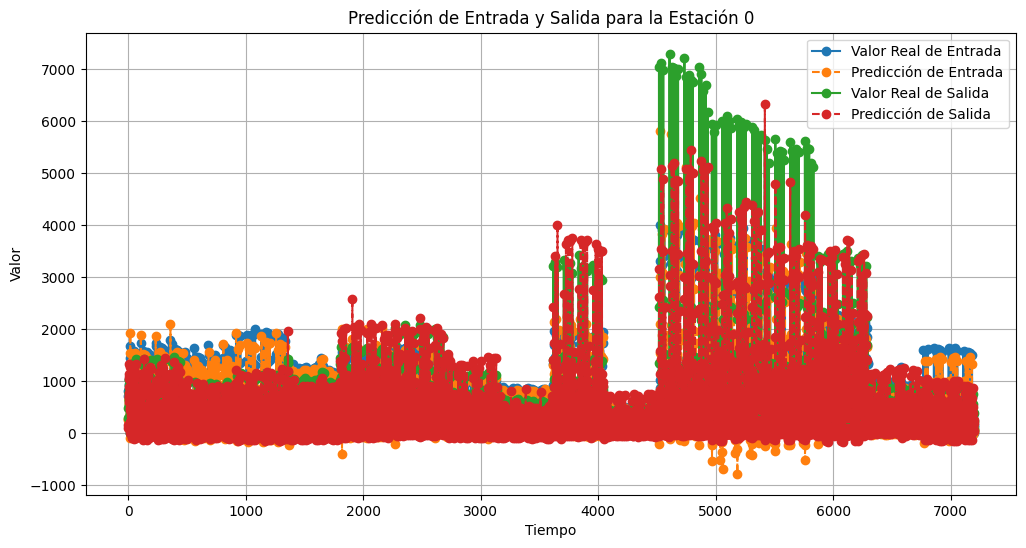

In [50]:
# Invertir la escala de las predicciones para obtener valores reales
predicted_data = scaler.inverse_transform(predicted_data)
# Desescalar los datos de prueba y las predicciones para obtener valores reales
y_test_actual = scaler.inverse_transform(y_test)
# Crear el gráfico
time_range = range(len(y_test_actual))
plt.figure(figsize=(12, 6))
plt.plot(time_range, y_test_actual[:, 0], label='Valor Real de Entrada', marker='o', linestyle='-')
plt.plot(time_range, predicted_data[:, 0], label='Predicción de Entrada', marker='o', linestyle='--')
plt.plot(time_range, y_test_actual[:, 1], label='Valor Real de Salida', marker='o', linestyle='-')
plt.plot(time_range, predicted_data[:, 1], label='Predicción de Salida', marker='o', linestyle='--')

plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Predicción de Entrada y Salida para la Estación 0')
plt.legend()
plt.grid(True)
plt.show()

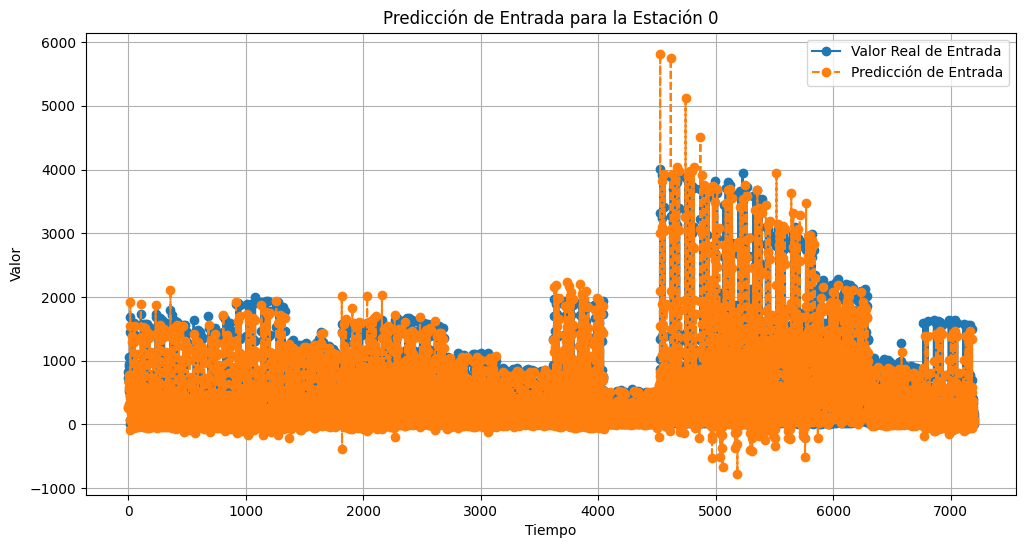

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(time_range, y_test_actual[:, 0], label='Valor Real de Entrada', marker='o', linestyle='-')
plt.plot(time_range, predicted_data[:, 0], label='Predicción de Entrada', marker='o', linestyle='--')

plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Predicción de Entrada para la Estación 0')
plt.legend()
plt.grid(True)
plt.show()

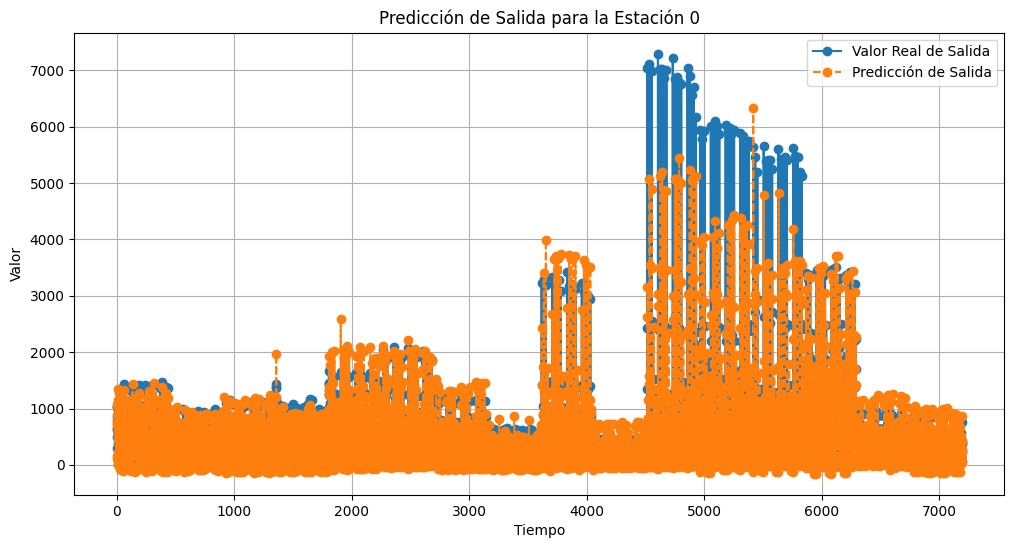

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(time_range, y_test_actual[:, 1], label='Valor Real de Salida', marker='o', linestyle='-')
plt.plot(time_range, predicted_data[:, 1], label='Predicción de Salida', marker='o', linestyle='--')

plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Predicción de Salida para la Estación 0')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
# Calcula el RMSE
rmse = np.sqrt(mean_squared_error(y_test_actual, predicted_data))

# Calcula el coeficiente de determinación (R-cuadrado)
r2 = r2_score(y_test_actual, predicted_data)

print("RMSE:", rmse)
print("R-cuadrado:", r2)

RMSE: 240.9169768097191
R-cuadrado: 0.839270752467477


Borramos variable

In [54]:
import gc
del lstm_df
gc.collect()

13402

### Prueba con datos junto con meteo

In [90]:
resultado_fecha_junta

,stationID,time,lineID,salida,entrada,temp,humidity,precip,windspeed
0,0,2019-01-01 06:00:00,2,0,17,3.0,80.66,0.0,14.4
1,0,2019-01-01 06:10:00,2,0,21,3.0,80.66,0.0,13.8
2,0,2019-01-01 06:20:00,2,1,30,3.0,80.66,0.0,13.2
3,0,2019-01-01 06:30:00,2,49,44,3.0,80.66,0.0,12.6
4,0,2019-01-01 06:40:00,2,48,31,3.0,80.66,0.0,12.0
...,...,...,...,...,...,...,...,...,...
213886,80,2019-01-25 23:10:00,1,24,3,7.2,71.29,0.0,14.4
213887,80,2019-01-25 23:20:00,1,9,2,7.2,71.29,0.0,14.4
213888,80,2019-01-25 23:30:00,1,7,0,7.2,71.29,0.0,14.4
213889,80,2019-01-25 23:40:00,1,5,1,7.2,71.29,0.0,14.4


In [76]:
# Escalar los datos
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(resultado_fecha_junta[['entrada', 'salida','stationID', 'lineID', 'temp', 'humidity', 'precip', 'windspeed']])

# Definir la longitud de la secuencia temporal
seq_length = 19  # Por ejemplo, utilizar las últimas 24 horas para predecir las próximas horas, pero utilizamos 19 porque no se toman datos de las 00:00 a las 04:00

# Crear secuencias temporales y etiquetas
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps, 2:])  # Selecciona las columnas 2 en adelante como variables de entrada (temp, humidity, precip, windspeed)
        y.append(data[i+n_steps, :2])  # Selecciona las columnas 0 y 1 como "entrada" y "salida"
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, seq_length)

In [78]:
# Dividir los datos en entrenamiento y prueba
train_size = int(len(X) * 0.8)  # Puedes ajustar la proporción según tus necesidades
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Crear y entrenar el modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 6)))  # 2 características: 'entrada' y 'salida'
model.add(Dense(2))  # 2 salidas para 'entrada' y 'salida'

model.compile(optimizer='adam', loss='mse')  # Puedes usar otra función de pérdida según tu problema

model.fit(X_train, y_train, epochs=50, batch_size=32)  # Ajusta los hiperparámetros según tus necesidades

# Realizar predicciones
predicted_data = model.predict(X_test)

Epoch 1/50
5347/5347 [==============================] - 13s 2ms/step - loss: 0.0026
Epoch 2/50
5347/5347 [==============================] - 12s 2ms/step - loss: 0.0024
Epoch 3/50
5347/5347 [==============================] - 12s 2ms/step - loss: 0.0023
Epoch 4/50
5347/5347 [==============================] - 12s 2ms/step - loss: 0.0023
Epoch 5/50
5347/5347 [==============================] - 11s 2ms/step - loss: 0.0022
Epoch 6/50
5347/5347 [==============================] - 11s 2ms/step - loss: 0.0022
Epoch 7/50
5347/5347 [==============================] - 11s 2ms/step - loss: 0.0023
Epoch 8/50
5347/5347 [==============================] - 11s 2ms/step - loss: 0.0022
Epoch 9/50
5347/5347 [==============================] - 11s 2ms/step - loss: 0.0022
Epoch 10/50
5347/5347 [==============================] - 11s 2ms/step - loss: 0.0019
Epoch 11/50
5347/5347 [==============================] - 11s 2ms/step - loss: 0.0020
Epoch 12/50
5347/5347 [==============================] - 12s 2ms/step - lo

In [125]:
predicted_data.shape

(42775, 2)

AttributeError: 'MinMaxScaler' object has no attribute 'shape'

In [126]:
# Invertir la escala de las predicciones para obtener valores reales
predicted_data = scaler.inverse_transform(predicted_data)
y_test_actual = scaler.inverse_transform(y_test)
# Crear el gráfico
time_range = range(len(y_test_actual))
plt.figure(figsize=(12, 6))
plt.plot(time_range, y_test_actual[:, 0], label='Valor Real de Entrada', marker='o', linestyle='-')
plt.plot(time_range, predicted_data[:, 0], label='Predicción de Entrada', marker='o', linestyle='--')
plt.plot(time_range, y_test_actual[:, 1], label='Valor Real de Salida', marker='o', linestyle='-')
plt.plot(time_range, predicted_data[:, 1], label='Predicción de Salida', marker='o', linestyle='--')

plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Predicción de Entrada y Salida para la Estación 0')
plt.legend()
plt.grid(True)
plt.show()

ValueError: operands could not be broadcast together with shapes (42775,2) (8,) (42775,2) 

## ARIMA

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima

### Intento manual

In [ ]:
arima_df = records.set_index('time')
arima_df = arima_df.groupby(['stationID', pd.Grouper(freq='H', level=0), 'status'])['userID'].count().unstack(fill_value=0)
arima_df.rename(columns={0: 'salida', 1: 'entrada'}, inplace=True)
arima_df.reset_index(inplace=True)
arima_df.set_index('time', inplace=True)

In [ ]:
arima_df

status,stationID,salida,entrada
time,,,
2019-01-01 06:00:00,0,123,209
2019-01-01 07:00:00,0,159,623
2019-01-01 08:00:00,0,271,818
2019-01-01 09:00:00,0,425,1035
2019-01-01 10:00:00,0,562,1152
...,...,...,...
2019-01-25 19:00:00,80,416,156
2019-01-25 20:00:00,80,371,182
2019-01-25 21:00:00,80,395,156


In [ ]:
station_data = arima_df[arima_df['stationID'] == 0]
station_data

status,stationID,salida,entrada
time,,,
2019-01-01 06:00:00,0,123,209
2019-01-01 07:00:00,0,159,623
2019-01-01 08:00:00,0,271,818
2019-01-01 09:00:00,0,425,1035
2019-01-01 10:00:00,0,562,1152
...,...,...,...
2019-01-25 19:00:00,0,722,324
2019-01-25 20:00:00,0,611,225
2019-01-25 21:00:00,0,571,207


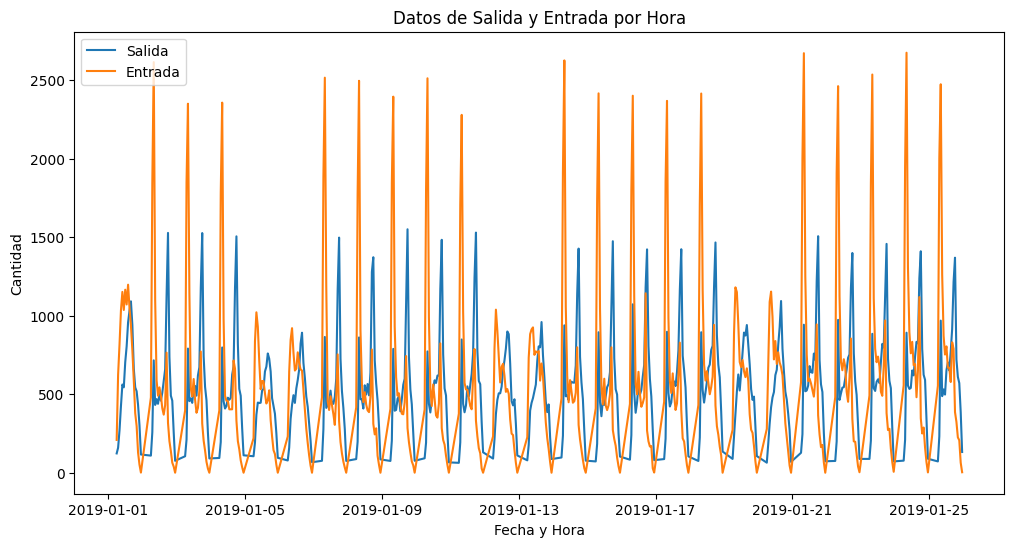

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(station_data["salida"], label="Salida")
plt.plot(station_data["entrada"], label="Entrada")
plt.xlabel("Fecha y Hora")
plt.ylabel("Cantidad")
plt.legend()
plt.title("Datos de Salida y Entrada por Hora")
plt.show()

In [ ]:
# Realiza una prueba de estacionariedad
def adf_test(series):
    result = adfuller(series, autolag="AIC")
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])

adf_test(station_data["salida"])  # Realiza la prueba para la serie de salida
adf_test(station_data["entrada"])  # Realiza la prueba para la serie de entrada


ADF Statistic: -3.065137641477475
p-value: 0.029243060072790338
Critical Values: {'1%': -3.445613745346461, '5%': -2.868269325317112, '10%': -2.5703544951308404}
ADF Statistic: -3.2645160868227183
p-value: 0.016541055574461866
Critical Values: {'1%': -3.445613745346461, '5%': -2.868269325317112, '10%': -2.5703544951308404}


In [ ]:
# Diferencia los datos si es necesario para hacerlos estacionarios
station_data['salida_diff'] = station_data['salida'].diff().dropna()
station_data['entrada_diff'] = station_data['entrada'].diff().dropna()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3440\1514571678.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_data['salida_diff'] = station_data['salida'].diff().dropna()
C:\Users\Usuario\AppData\Local\Temp\ipykernel_3440\1514571678.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_data['entrada_diff'] = station_data['entrada'].diff().dropna()


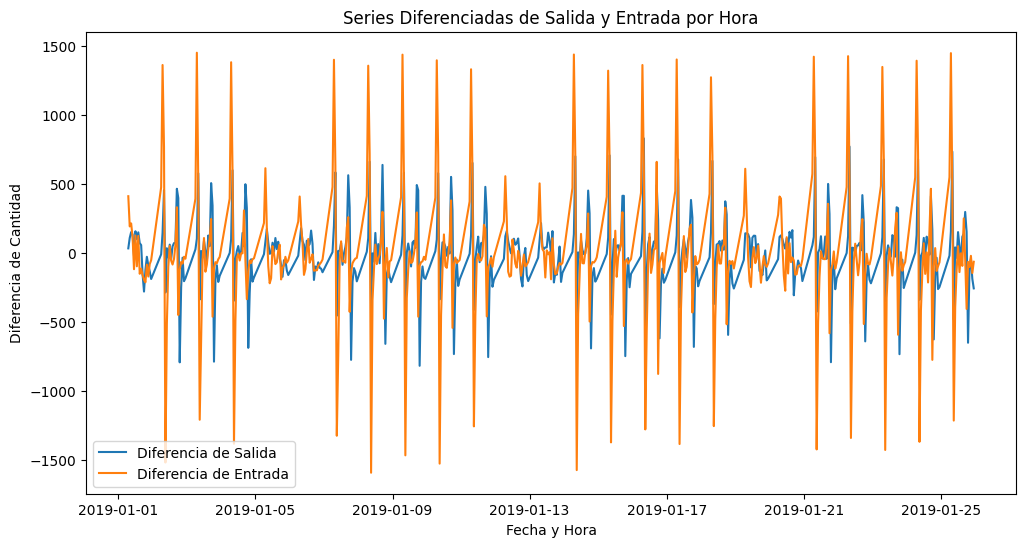

In [ ]:
# Visualiza las series diferenciadas
plt.figure(figsize=(12, 6))
plt.plot(station_data["salida_diff"], label="Diferencia de Salida")
plt.plot(station_data["entrada_diff"], label="Diferencia de Entrada")
plt.xlabel("Fecha y Hora")
plt.ylabel("Diferencia de Cantidad")
plt.legend()
plt.title("Series Diferenciadas de Salida y Entrada por Hora")
plt.show()

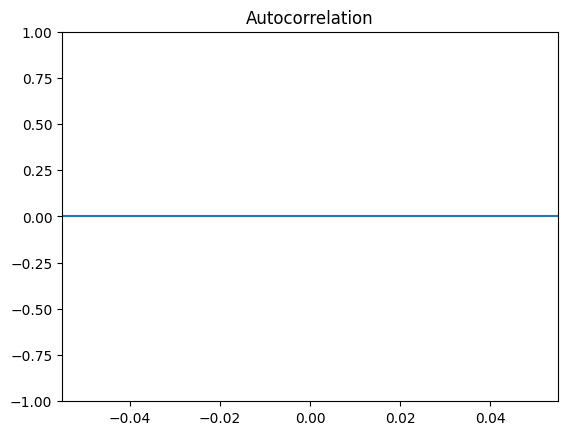

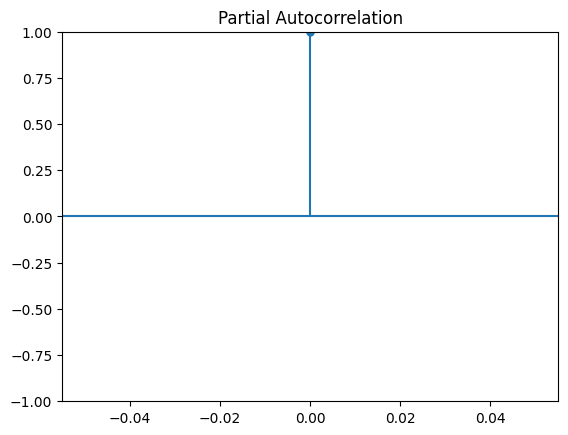

In [ ]:
# Realiza un análisis de autocorrelación y autocorrelación parcial
plot_acf(station_data["salida_diff"], lags=40)
plot_pacf(station_data["salida_diff"], lags=40)
plt.show()

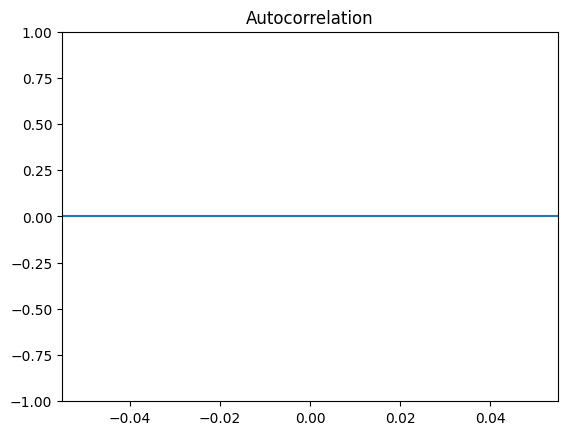

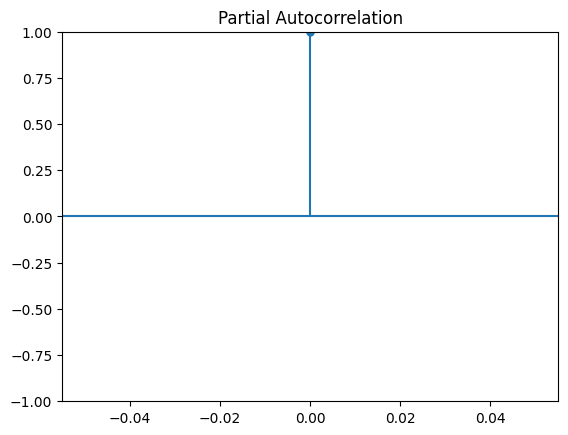

In [ ]:
plot_acf(station_data["entrada_diff"], lags=40)
plot_pacf(station_data["entrada_diff"], lags=40)
plt.show()

In [ ]:
# Ajusta el modelo ARIMA
model_salida = ARIMA(station_data["salida"], order=(1, 1, 1))
model_entrada = ARIMA(station_data["entrada"], order=(1, 1, 1))

c:\Users\Usuario\Documents\TFM Enrique Cueto\Code\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Usuario\Documents\TFM Enrique Cueto\Code\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Usuario\Documents\TFM Enrique Cueto\Code\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Usuario\Documents\TFM Enrique Cueto\Code\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been

In [ ]:
# Ajusta el modelo a los datos
model_salida_fit = model_salida.fit()
model_entrada_fit = model_entrada.fit()

In [ ]:
# Realiza predicciones
n_forecast = 24  # Número de pasos hacia adelante a predecir

forecast_salida = model_salida_fit.forecast(steps=n_forecast)
forecast_entrada = model_entrada_fit.forecast(steps=n_forecast)

c:\Users\Usuario\Documents\TFM Enrique Cueto\Code\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Usuario\Documents\TFM Enrique Cueto\Code\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Usuario\Documents\TFM Enrique Cueto\Code\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


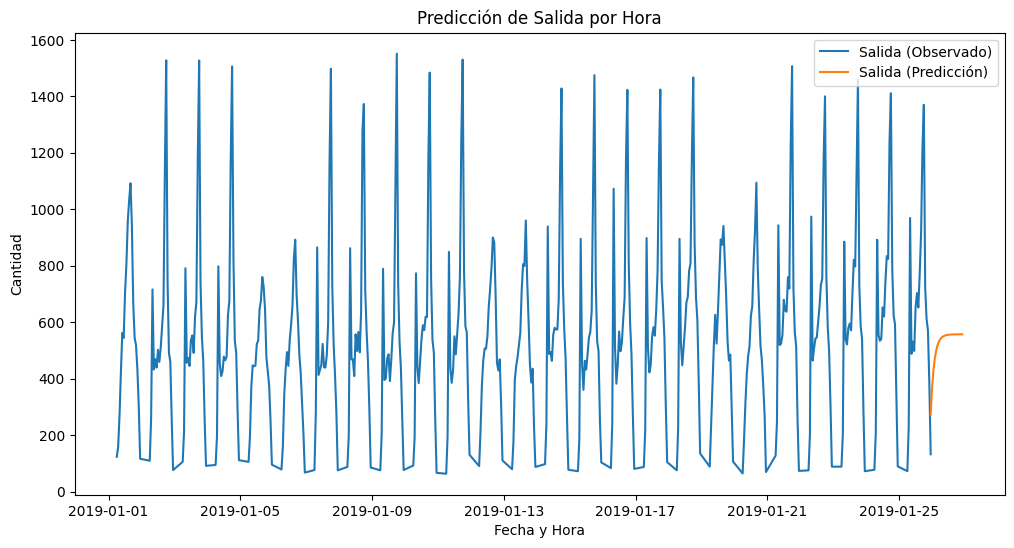

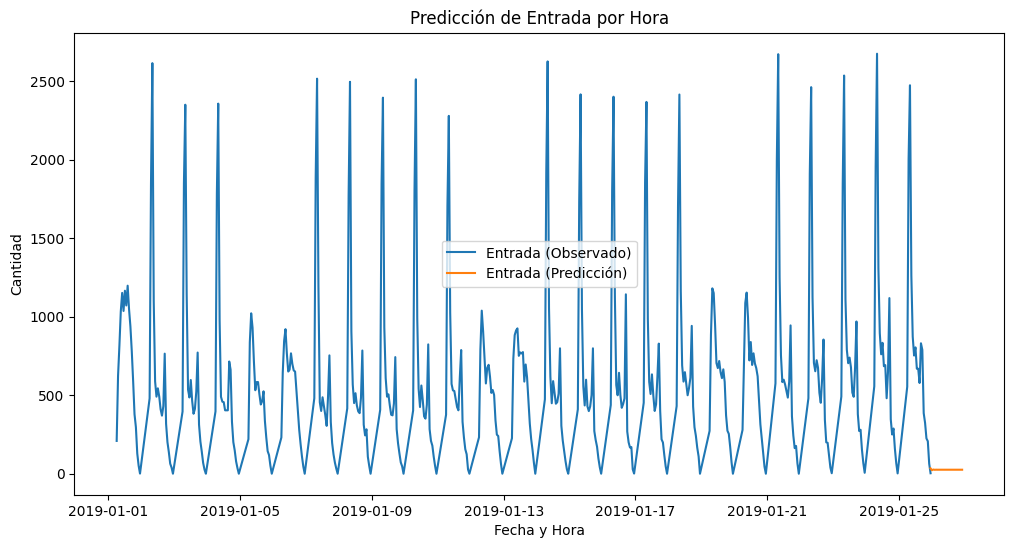

In [ ]:
# Visualiza las predicciones
plt.figure(figsize=(12, 6))
plt.plot(station_data.index, station_data["salida"], label="Salida (Observado)")
plt.plot(pd.date_range(start=station_data.index[-1], periods=n_forecast, freq="H"), forecast_salida, label="Salida (Predicción)")
plt.xlabel("Fecha y Hora")
plt.ylabel("Cantidad")
plt.legend()
plt.title("Predicción de Salida por Hora")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(station_data.index, station_data["entrada"], label="Entrada (Observado)")
plt.plot(pd.date_range(start=station_data.index[-1], periods=n_forecast, freq="H"), forecast_entrada, label="Entrada (Predicción)")
plt.xlabel("Fecha y Hora")
plt.ylabel("Cantidad")
plt.legend()
plt.title("Predicción de Entrada por Hora")
plt.show()

### Intento automático

In [ ]:
arima_df = records.set_index('time')
arima_df = arima_df.groupby(['stationID', pd.Grouper(freq='H', level=0), 'status'])['userID'].count().unstack(fill_value=0)
arima_df.rename(columns={0: 'salida', 1: 'entrada'}, inplace=True)
arima_df.reset_index(inplace=True)
arima_df.set_index('time', inplace=True)

In [ ]:
station_data = arima_df[arima_df['stationID'] == 0]
station_data

status,stationID,salida,entrada
time,,,
2019-01-01 06:00:00,0,123,209
2019-01-01 07:00:00,0,159,623
2019-01-01 08:00:00,0,271,818
2019-01-01 09:00:00,0,425,1035
2019-01-01 10:00:00,0,562,1152
...,...,...,...
2019-01-25 19:00:00,0,722,324
2019-01-25 20:00:00,0,611,225
2019-01-25 21:00:00,0,571,207


In [ ]:
# Separa tus datos en conjuntos de entrenamiento y prueba
train_size = int(len(station_data) * 0.8)
train_data = station_data.iloc[:train_size]
test_data = station_data.iloc[train_size:]

In [ ]:
model_entrada = auto_arima(train_data['entrada'], seasonal=True, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5231.702, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5539.193, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5347.557, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5276.151, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5824.186, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5233.573, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5229.760, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5243.873, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=5240.250, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=5231.523, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=5233.980, Time=0.02 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=5231.844, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5307.279, Time=0.04 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 0.728 seconds


In [ ]:
model_salida = auto_arima(train_data['salida'], seasonal=True, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4932.462, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5164.647, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4948.250, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4978.228, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5663.150, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4930.914, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=4937.504, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4928.902, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4929.281, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4927.193, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4929.049, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4931.049, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4993.515, Time=0.01 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.460 seconds


In [ ]:
# Ajusta el modelo ARIMA con los parámetros óptimos encontrados
model_entrada.fit(train_data['entrada'])
model_salida.fit(train_data['salida'])

ARIMA(order=(2, 0, 0), scoring_args={}, suppress_warnings=True)

In [ ]:
# Realiza predicciones en el conjunto de prueba
predictions_entrada = model_entrada.predict(n_periods=len(test_data))
predictions_salida = model_salida.predict(n_periods=len(test_data))

c:\Users\Usuario\Documents\TFM Enrique Cueto\Code\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Usuario\Documents\TFM Enrique Cueto\Code\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Usuario\Documents\TFM Enrique Cueto\Code\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Usuario\Documents\TFM Enrique Cueto\Code\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In t

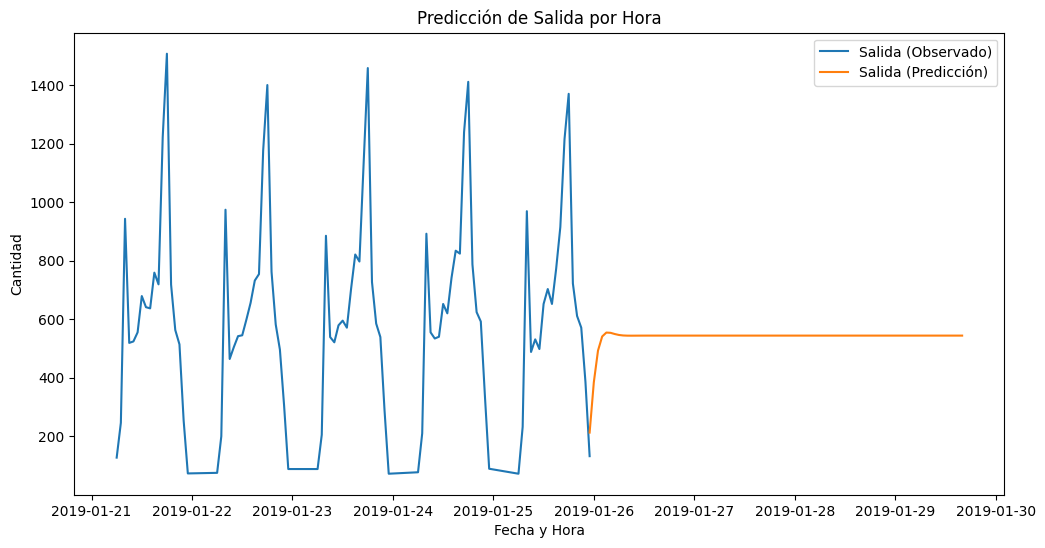

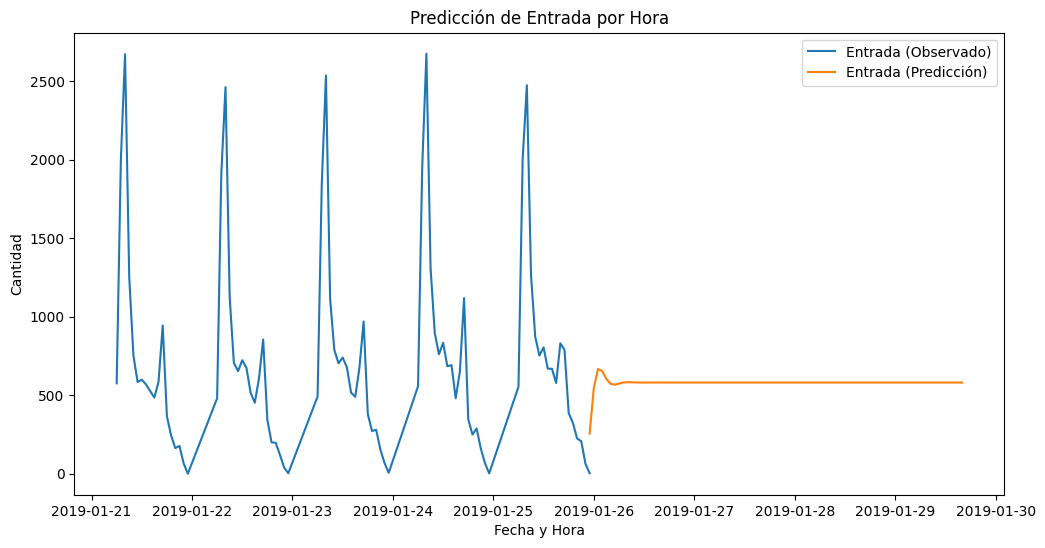

In [ ]:
# Visualiza las predicciones
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data["salida"], label="Salida (Observado)")
plt.plot(pd.date_range(start=test_data.index[-1], periods=len(test_data), freq="H"), predictions_salida, label="Salida (Predicción)")
plt.xlabel("Fecha y Hora")
plt.ylabel("Cantidad")
plt.legend()
plt.title("Predicción de Salida por Hora")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data["entrada"], label="Entrada (Observado)")
plt.plot(pd.date_range(start=test_data.index[-1], periods=len(test_data), freq="H"), predictions_entrada, label="Entrada (Predicción)")
plt.xlabel("Fecha y Hora")
plt.ylabel("Cantidad")
plt.legend()
plt.title("Predicción de Entrada por Hora")
plt.show()

In [ ]:
rmse_entrada = np.sqrt(mean_squared_error(test_data['entrada'], predictions_entrada))
print(f'RMSE: {rmse_entrada}')
rmse_salida = np.sqrt(mean_squared_error(test_data['salida'], predictions_salida))
print(f'RMSE: {rmse_salida}')

RMSE: 645.3504623091593
RMSE: 343.008714716622


In [ ]:
del arima_df
gc.collect()

23051

## PROPHET

In [135]:
from prophet import Prophet

c:\Users\Usuario\Documents\TFM Enrique Cueto\Code\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [ ]:
prophet_df = records.set_index('time')
prophet_df = prophet_df.groupby(['stationID', pd.Grouper(freq='H', level=0), 'status'])['userID'].count().unstack(fill_value=0)
prophet_df.rename(columns={0: 'salida', 1: 'entrada'}, inplace=True)
prophet_df.reset_index(inplace=True)
prophet_df.set_index('time', inplace=True)
prophet_df

status,stationID,salida,entrada
time,,,
2019-01-01 06:00:00,0,123,209
2019-01-01 07:00:00,0,159,623
2019-01-01 08:00:00,0,271,818
2019-01-01 09:00:00,0,425,1035
2019-01-01 10:00:00,0,562,1152
...,...,...,...
2019-01-25 19:00:00,80,416,156
2019-01-25 20:00:00,80,371,182
2019-01-25 21:00:00,80,395,156


In [ ]:
prophet_df.reset_index(inplace=True)

In [ ]:
# Renombrar las columnas a 'ds' y 'y', que son requeridas por Prophet
prophet_df = prophet_df.rename(columns={'time': 'ds', 'salida': 'y'})

In [ ]:
station_data = prophet_df[prophet_df['stationID'] == 0]
station_data = station_data.drop(columns=['stationID', 'entrada'])
station_data

status,ds,y
0,2019-01-01 06:00:00,123
1,2019-01-01 07:00:00,159
2,2019-01-01 08:00:00,271
3,2019-01-01 09:00:00,425
4,2019-01-01 10:00:00,562
...,...,...
445,2019-01-25 19:00:00,722
446,2019-01-25 20:00:00,611
447,2019-01-25 21:00:00,571
448,2019-01-25 22:00:00,386


In [ ]:
train_size = int(len(station_data) * 0.8)
train_data = station_data.iloc[:train_size]
test_data = station_data.iloc[train_size:]

In [ ]:
# Crear un modelo Prophet
model = Prophet()

# Ajustar el modelo a los datos
model.fit(train_data)

13:50:02 - cmdstanpy - INFO - Chain [1] start processing
13:50:02 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
#Usar para futuras predicciones, no en nuestro caso ya que usamos el conjunto de test para poder calcular el RMSE


# Crear un dataframe con fechas futuras para las predicciones
#future = model.make_future_dataframe(freq='H',periods=test_data['y'].size)  # Por ejemplo, predicciones para 30 días adicionales
#future.tail()

In [ ]:
# Realizar las predicciones
forecast = model.predict(test_data)

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
85,2019-01-25 19:00:00,907.044249,700.474933,1124.917821
86,2019-01-25 20:00:00,651.258685,420.541383,879.238702
87,2019-01-25 21:00:00,465.259364,248.365894,669.345997
88,2019-01-25 22:00:00,358.736005,142.216266,572.064089
89,2019-01-25 23:00:00,194.710904,-19.435238,411.946780


c:\Users\Usuario\Documents\TFM Enrique Cueto\Code\.venv\Lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Usuario\Documents\TFM Enrique Cueto\Code\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


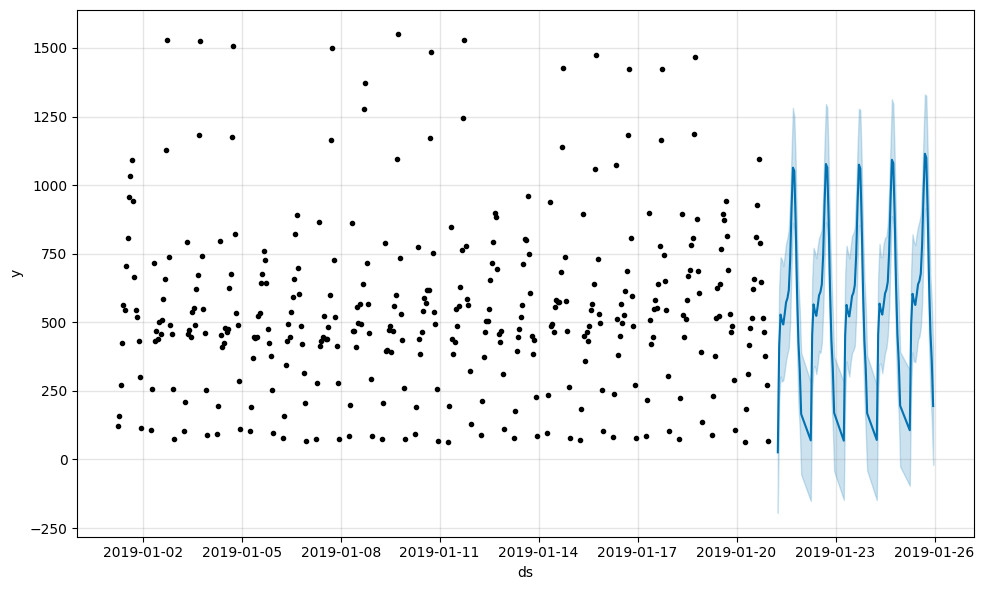

In [ ]:
# Visualizar las predicciones
fig = model.plot(forecast)
plt.show()

In [ ]:
rmse_salida = np.sqrt(mean_squared_error(test_data['y'], forecast['yhat']))
print(f'RMSE: {rmse_salida}')

RMSE: 152.38702683254482


In [ ]:
del prophet_df
gc.collect()

1757

### Cada 10 min y Meteo incluido

In [131]:
resultado_fecha_junta

,stationID,time,lineID,salida,entrada,temp,humidity,precip,windspeed
0,0,2019-01-01 06:00:00,2,0,17,3.0,80.66,0.0,14.4
1,0,2019-01-01 06:10:00,2,0,21,3.0,80.66,0.0,13.8
2,0,2019-01-01 06:20:00,2,1,30,3.0,80.66,0.0,13.2
3,0,2019-01-01 06:30:00,2,49,44,3.0,80.66,0.0,12.6
4,0,2019-01-01 06:40:00,2,48,31,3.0,80.66,0.0,12.0
...,...,...,...,...,...,...,...,...,...
213886,80,2019-01-25 23:10:00,1,24,3,7.2,71.29,0.0,14.4
213887,80,2019-01-25 23:20:00,1,9,2,7.2,71.29,0.0,14.4
213888,80,2019-01-25 23:30:00,1,7,0,7.2,71.29,0.0,14.4
213889,80,2019-01-25 23:40:00,1,5,1,7.2,71.29,0.0,14.4


In [146]:
prophet_df_salida = resultado_fecha_junta.rename(columns={'time': 'ds', 'salida': 'y'})
prophet_df_entrada = resultado_fecha_junta.rename(columns={'time': 'ds', 'entrada': 'y'})

In [147]:
#Datos entrenamiento salida
train_size = int(len(prophet_df_salida) * 0.8)
train_data_salida = prophet_df_salida.iloc[:train_size]
test_data_salida = prophet_df_salida.iloc[train_size:]

In [148]:
#Datos entrenamiento entrada
train_size = int(len(prophet_df_entrada) * 0.8)
train_data_entrada = prophet_df_entrada.iloc[:train_size]
test_data_entrada = prophet_df_entrada.iloc[train_size:]

In [152]:
train_data_salida

,stationID,ds,lineID,y,entrada,temp,humidity,precip,windspeed
0,0,2019-01-01 06:00:00,2,0,17,3.000000,80.660000,0.0,14.4
1,0,2019-01-01 06:10:00,2,0,21,3.000000,80.660000,0.0,13.8
2,0,2019-01-01 06:20:00,2,1,30,3.000000,80.660000,0.0,13.2
3,0,2019-01-01 06:30:00,2,49,44,3.000000,80.660000,0.0,12.6
4,0,2019-01-01 06:40:00,2,48,31,3.000000,80.660000,0.0,12.0
...,...,...,...,...,...,...,...,...,...
171107,64,2019-01-22 13:50:00,3,35,26,12.500000,32.348333,0.0,15.0
171108,64,2019-01-22 14:00:00,3,28,20,12.600000,32.320000,0.0,14.4
171109,64,2019-01-22 14:10:00,3,22,31,12.666667,32.005000,0.0,14.4
171110,64,2019-01-22 14:20:00,3,26,30,12.733333,31.690000,0.0,14.4


In [154]:
# Crear un modelo Prophet
model = Prophet()
model.add_regressor('stationID')
model.add_regressor('lineID')
model.add_regressor('temp')
model.add_regressor('humidity')
model.add_regressor('precip')
model.add_regressor('windspeed')
# Ajustar el modelo a los datos
model.fit(train_data_salida)

13:43:46 - cmdstanpy - INFO - Chain [1] start processing
13:44:25 - cmdstanpy - INFO - Chain [1] done processing


c:\Users\Usuario\Documents\TFM Enrique Cueto\Code\.venv\Lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Usuario\Documents\TFM Enrique Cueto\Code\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


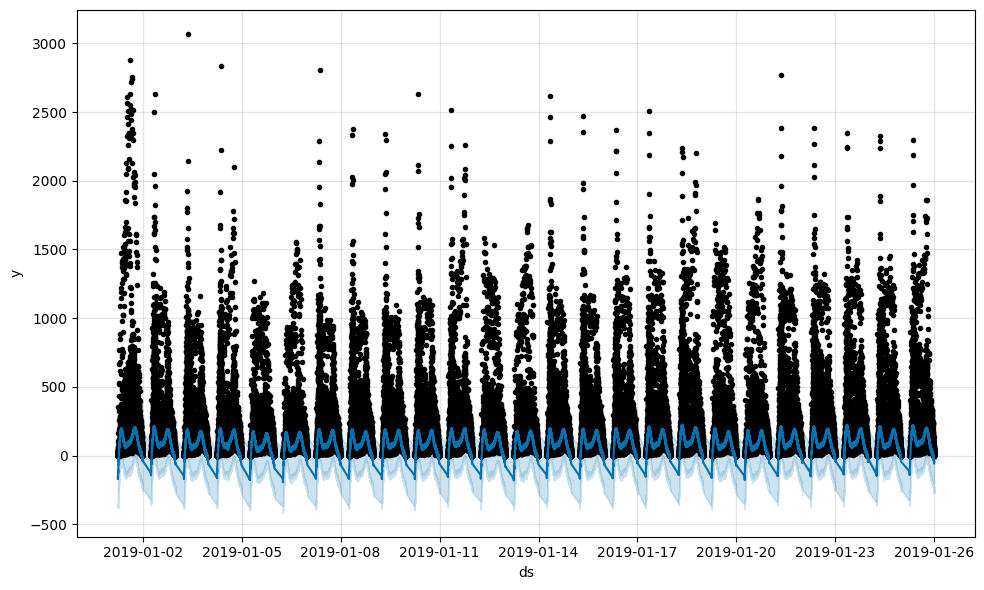

In [155]:
# Realizar las predicciones
forecast = model.predict(test_data_salida)
# Visualizar las predicciones
fig = model.plot(forecast)
plt.show()

In [156]:
rmse_salida = np.sqrt(mean_squared_error(test_data_salida['y'], forecast['yhat']))
print(f'RMSE: {rmse_salida}')

RMSE: 131.6619500943818


## RANDOM FOREST

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
rnn_df = records.set_index('time')
rnn_df = rnn_df.groupby(['stationID', pd.Grouper(freq='H', level=0), 'status'])['userID'].count().unstack(fill_value=0)
rnn_df.rename(columns={0: 'salida', 1: 'entrada'}, inplace=True)
rnn_df.reset_index(inplace=True)
rnn_df

status,stationID,time,salida,entrada
0,0,2019-01-01 06:00:00,123,209
1,0,2019-01-01 07:00:00,159,623
2,0,2019-01-01 08:00:00,271,818
3,0,2019-01-01 09:00:00,425,1035
4,0,2019-01-01 10:00:00,562,1152
...,...,...,...,...
35995,80,2019-01-25 19:00:00,416,156
35996,80,2019-01-25 20:00:00,371,182
35997,80,2019-01-25 21:00:00,395,156
35998,80,2019-01-25 22:00:00,244,121


In [ ]:
rnn_df['year'] = rnn_df['time'].dt.year
rnn_df['month'] = rnn_df['time'].dt.month
rnn_df['day'] = rnn_df['time'].dt.day
rnn_df['hour'] = rnn_df['time'].dt.hour
rnn_df.drop(columns=['time'], inplace=True)
rnn_df

status,stationID,salida,entrada,year,month,day,hour
0,0,123,209,2019,1,1,6
1,0,159,623,2019,1,1,7
2,0,271,818,2019,1,1,8
3,0,425,1035,2019,1,1,9
4,0,562,1152,2019,1,1,10
...,...,...,...,...,...,...,...
35995,80,416,156,2019,1,25,19
35996,80,371,182,2019,1,25,20
35997,80,395,156,2019,1,25,21
35998,80,244,121,2019,1,25,22


In [ ]:
# Aquí, seleccionaremos las características (estación y hora) y el objetivo (salida y entrada)
X = rnn_df[['stationID', 'year', 'month', 'day', 'hour']].values
y_salida = rnn_df['salida'].values
y_entrada = rnn_df['entrada'].values

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_salida_train, y_salida_test, y_entrada_train, y_entrada_test = train_test_split(X, y_salida, y_entrada, test_size=0.2, random_state=42)

In [ ]:
# Crear y entrenar el modelo Random Forest para la variable "salida"
rf_salida = RandomForestRegressor(n_estimators=100, random_state=42)
rf_salida.fit(X_train, y_salida_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Realizar predicciones para la variable "salida"
y_salida_pred = rf_salida.predict(X_test)

In [ ]:
# Evaluar el modelo
rmse_salida = np.sqrt(mean_squared_error(y_salida_test, y_salida_pred))
r2_salida = r2_score(y_salida_test, y_salida_pred)

print(f"Root Mean Squared Error (RMSE) para la variable 'salida': {rmse_salida}")
print(f"Coeficiente de determinación (R^2) para la variable 'salida': {r2_salida}")

Root Mean Squared Error (RMSE) para la variable 'salida': 214.45019927165555
Coeficiente de determinación (R^2) para la variable 'salida': 0.9558688840042278


In [ ]:
# Crear y entrenar el modelo Random Forest para la variable "entrada"
rf_entrada = RandomForestRegressor(n_estimators=100, random_state=42)
rf_entrada.fit(X_train, y_entrada_train)

# Realizar predicciones para la variable "entrada"
y_entrada_pred = rf_entrada.predict(X_test)

# Evaluar el modelo
rmse_entrada = np.sqrt(mean_squared_error(y_entrada_test, y_entrada_pred))
r2_entrada = r2_score(y_entrada_test, y_entrada_pred)

print(f"Root Mean Squared Error (RMSE) para la variable 'entrada': {rmse_entrada}")
print(f"Coeficiente de determinación (R^2) para la variable 'entrada': {r2_entrada}")

Root Mean Squared Error (RMSE) para la variable 'entrada': 202.9591011651116
Coeficiente de determinación (R^2) para la variable 'entrada': 0.9558102963894346


In [ ]:
X_test

array([[  36, 2019,    1,   15,   15],
       [  52, 2019,    1,   10,   23],
       [  52, 2019,    1,   14,   12],
       ...,
       [  20, 2019,    1,   21,   16],
       [  17, 2019,    1,   25,   18],
       [  28, 2019,    1,   18,   15]], dtype=int64)

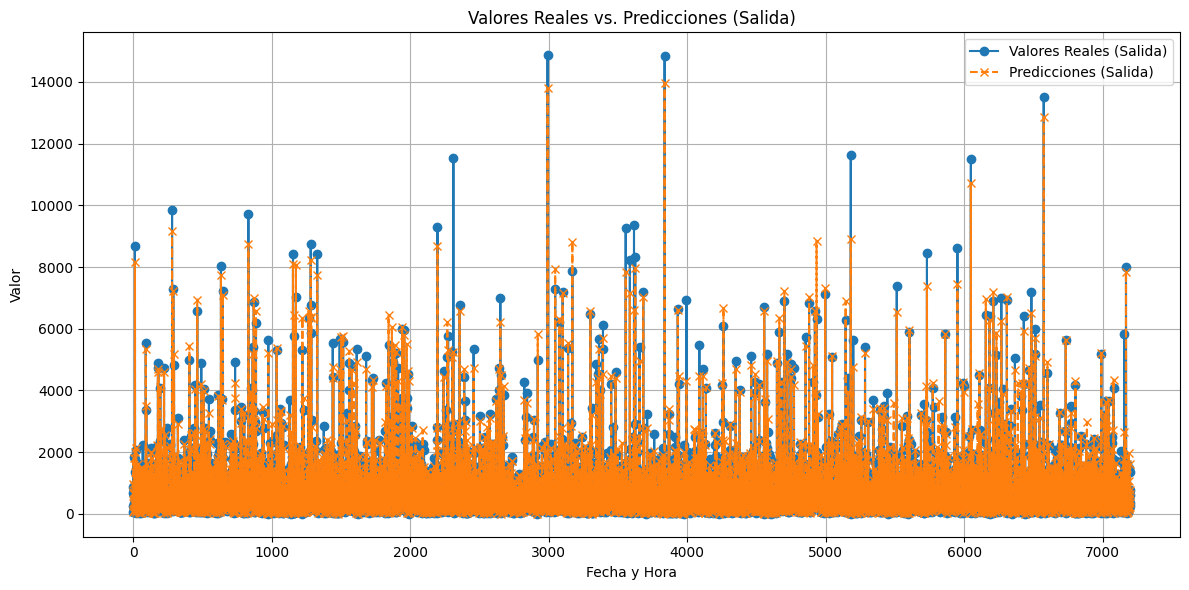

In [ ]:
# Gráfico de valores reales y predicciones para la columna "salida"
plt.figure(figsize=(12, 6))
plt.plot(y_salida_test, label='Valores Reales (Salida)', marker='o')
plt.plot(y_salida_pred, label='Predicciones (Salida)', linestyle='--', marker='x')

# Configuración de etiquetas y leyenda
plt.xlabel('Fecha y Hora')
plt.ylabel('Valor')
plt.title('Valores Reales vs. Predicciones (Salida)')
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

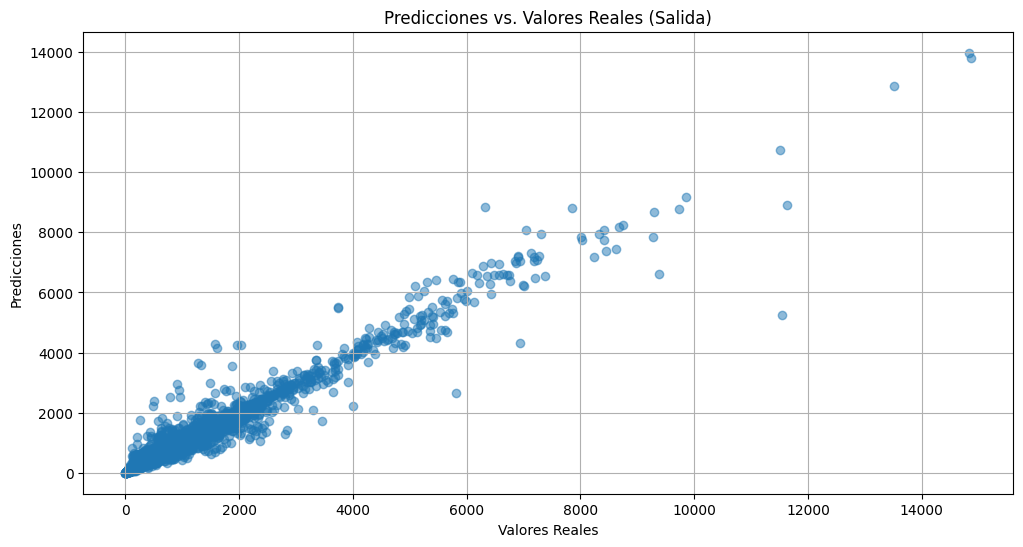

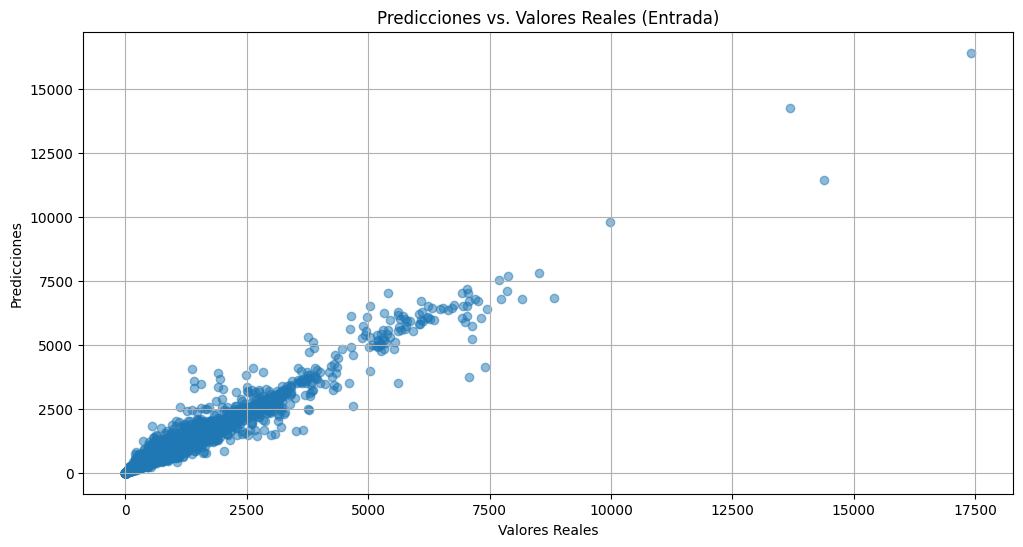

In [ ]:
import matplotlib.pyplot as plt

# Gráfico para la variable "salida"
plt.figure(figsize=(12, 6))
plt.scatter(y_salida_test, y_salida_pred, alpha=0.5)
plt.title('Predicciones vs. Valores Reales (Salida)')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid(True)
plt.show()

# Gráfico para la variable "entrada"
plt.figure(figsize=(12, 6))
plt.scatter(y_entrada_test, y_entrada_pred, alpha=0.5)
plt.title('Predicciones vs. Valores Reales (Entrada)')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid(True)
plt.show()

In [ ]:
y_entrada_pred

array([ 212.73,   40.27,  772.76, ..., 1719.93,  557.15,  206.94])

### Cada 10 min Meteo incluido

In [91]:
resultado

,stationID,lineID,salida,entrada,temp,humidity,precip,windspeed,year,month,day,hour
0,0,2,0,17,3.0,80.66,0.0,14.4,2019,1,1,6
1,0,2,0,21,3.0,80.66,0.0,13.8,2019,1,1,6
2,0,2,1,30,3.0,80.66,0.0,13.2,2019,1,1,6
3,0,2,49,44,3.0,80.66,0.0,12.6,2019,1,1,6
4,0,2,48,31,3.0,80.66,0.0,12.0,2019,1,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...
213886,80,1,24,3,7.2,71.29,0.0,14.4,2019,1,25,23
213887,80,1,9,2,7.2,71.29,0.0,14.4,2019,1,25,23
213888,80,1,7,0,7.2,71.29,0.0,14.4,2019,1,25,23
213889,80,1,5,1,7.2,71.29,0.0,14.4,2019,1,25,23


In [94]:
X = resultado[['stationID', 'year', 'month', 'day', 'hour', 'lineID', 'temp', 'humidity', 'precip', 'windspeed']].values
y_salida = resultado['salida'].values
y_entrada = resultado['entrada'].values
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_salida_train, y_salida_test, y_entrada_train, y_entrada_test = train_test_split(X, y_salida, y_entrada, test_size=0.2, random_state=42)

In [95]:
# Crear y entrenar el modelo Random Forest para la variable "salida"
rf_salida = RandomForestRegressor(n_estimators=100, random_state=42)
rf_salida.fit(X_train, y_salida_train)

# Realizar predicciones para la variable "salida"
y_salida_pred = rf_salida.predict(X_test)

# Evaluar el modelo
rmse_salida = np.sqrt(mean_squared_error(y_salida_test, y_salida_pred))
r2_salida = r2_score(y_salida_test, y_salida_pred)

print(f"Root Mean Squared Error (RMSE) para la variable 'salida': {rmse_salida}")
print(f"Coeficiente de determinación (R^2) para la variable 'salida': {r2_salida}")

Root Mean Squared Error (RMSE) para la variable 'salida': 44.20593808945205
Coeficiente de determinación (R^2) para la variable 'salida': 0.9339384341104725


In [96]:
# Crear y entrenar el modelo Random Forest para la variable "entrada"
rf_entrada = RandomForestRegressor(n_estimators=100, random_state=42)
rf_entrada.fit(X_train, y_entrada_train)

# Realizar predicciones para la variable "entrada"
y_entrada_pred = rf_entrada.predict(X_test)

# Evaluar el modelo
rmse_entrada = np.sqrt(mean_squared_error(y_entrada_test, y_entrada_pred))
r2_entrada = r2_score(y_entrada_test, y_entrada_pred)

print(f"Root Mean Squared Error (RMSE) para la variable 'entrada': {rmse_entrada}")
print(f"Coeficiente de determinación (R^2) para la variable 'entrada': {r2_entrada}")

Root Mean Squared Error (RMSE) para la variable 'entrada': 38.976742466636594
Coeficiente de determinación (R^2) para la variable 'entrada': 0.9438013727939821


## XGBOOST

In [97]:
from xgboost import XGBRegressor

In [112]:
rnn_df = records.set_index('time')
rnn_df = rnn_df.groupby(['stationID', pd.Grouper(freq='H', level=0), 'status'])['userID'].count().unstack(fill_value=0)
rnn_df.rename(columns={0: 'salida', 1: 'entrada'}, inplace=True)
rnn_df.reset_index(inplace=True)


rnn_df['year'] = rnn_df['time'].dt.year
rnn_df['month'] = rnn_df['time'].dt.month
rnn_df['day'] = rnn_df['time'].dt.day
rnn_df['hour'] = rnn_df['time'].dt.hour
rnn_df.drop(columns=['time'], inplace=True)

# Aquí, seleccionaremos las características (estación y hora) y el objetivo (salida y entrada)
X = rnn_df[['stationID', 'year', 'month', 'day', 'hour']].values
y_salida = rnn_df['salida'].values
y_entrada = rnn_df['entrada'].values

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_salida_train, y_salida_test, y_entrada_train, y_entrada_test = train_test_split(X, y_salida, y_entrada, test_size=0.2, random_state=42)

In [124]:
rnn_df

status,stationID,salida,entrada,year,month,day,hour
0,0,123,209,2019,1,1,6
1,0,159,623,2019,1,1,7
2,0,271,818,2019,1,1,8
3,0,425,1035,2019,1,1,9
4,0,562,1152,2019,1,1,10
...,...,...,...,...,...,...,...
35995,80,416,156,2019,1,25,19
35996,80,371,182,2019,1,25,20
35997,80,395,156,2019,1,25,21
35998,80,244,121,2019,1,25,22


In [113]:
# Crear y entrenar el modelo XGBoost para la variable "salida"
xgb_salida = XGBRegressor(n_estimators=100, random_state=42)
xgb_salida.fit(X_train, y_salida_train)

# Realizar predicciones para la variable "salida"
y_salida_pred = xgb_salida.predict(X_test)

# Evaluar el modelo para la variable "salida"
rmse_salida = np.sqrt(mean_squared_error(y_salida_test, y_salida_pred))
r2_salida = r2_score(y_salida_test, y_salida_pred)

print(f"Root Mean Squared Error (RMSE) para la variable 'salida': {rmse_salida}")
print(f"Coeficiente de determinación (R^2) para la variable 'salida': {r2_salida}")

Root Mean Squared Error (RMSE) para la variable 'salida': 219.45499469721528
Coeficiente de determinación (R^2) para la variable 'salida': 0.9537850017289722


In [114]:
# Crear y entrenar el modelo XGBoost para la variable "entrada"
xgb_entrada = XGBRegressor(n_estimators=100, random_state=42)
xgb_entrada.fit(X_train, y_entrada_train)

# Realizar predicciones para la variable "entrada"
y_entrada_pred = xgb_entrada.predict(X_test)

# Evaluar el modelo para la variable "entrada"
rmse_entrada = np.sqrt(mean_squared_error(y_entrada_test, y_entrada_pred))
r2_entrada = r2_score(y_entrada_test, y_entrada_pred)

print(f"Root Mean Squared Error (RMSE) para la variable 'entrada': {rmse_entrada}")
print(f"Coeficiente de determinación (R^2) para la variable 'entrada': {r2_entrada}")

Root Mean Squared Error (RMSE) para la variable 'entrada': 200.21149728389554
Coeficiente de determinación (R^2) para la variable 'entrada': 0.9569986535882892


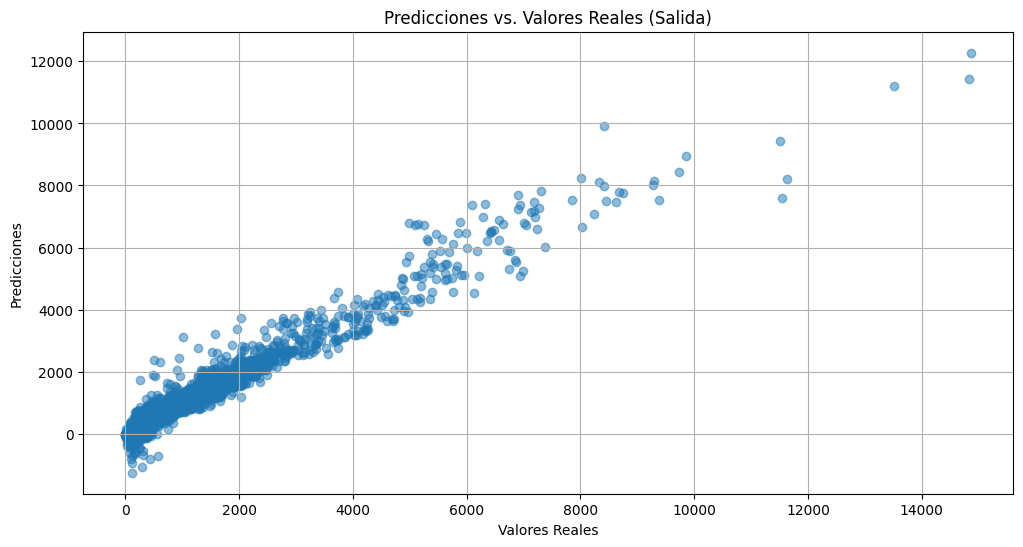

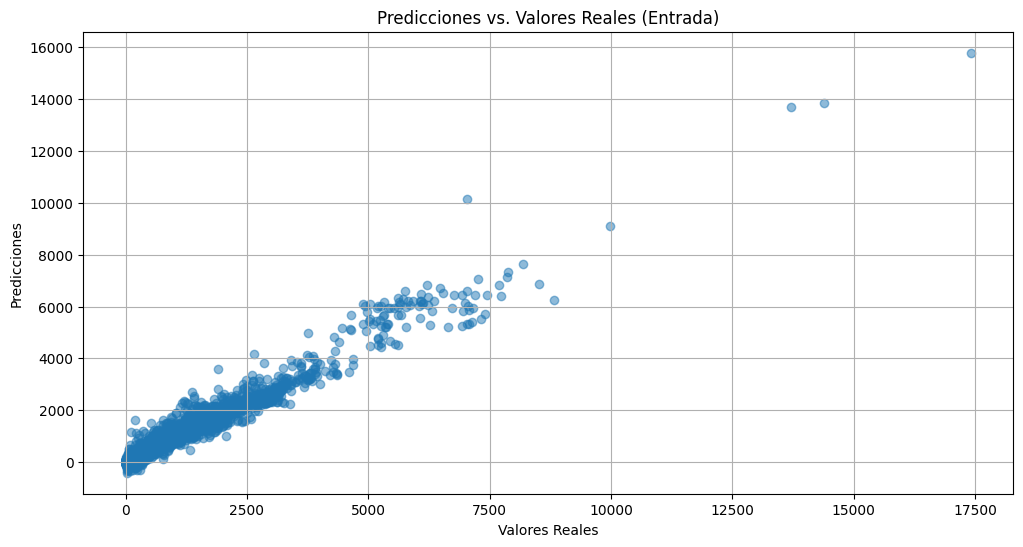

In [115]:
# Gráfico para la variable "salida"
plt.figure(figsize=(12, 6))
plt.scatter(y_salida_test, y_salida_pred, alpha=0.5)
plt.title('Predicciones vs. Valores Reales (Salida)')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid(True)
plt.show()

# Gráfico para la variable "entrada"
plt.figure(figsize=(12, 6))
plt.scatter(y_entrada_test, y_entrada_pred, alpha=0.5)
plt.title('Predicciones vs. Valores Reales (Entrada)')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid(True)
plt.show()

### Cada 10 min y Meteo incluido

In [123]:
resultado

,stationID,lineID,salida,entrada,temp,humidity,precip,windspeed,year,month,day,hour
0,0,2,0,17,3.0,80.66,0.0,14.4,2019,1,1,6
1,0,2,0,21,3.0,80.66,0.0,13.8,2019,1,1,6
2,0,2,1,30,3.0,80.66,0.0,13.2,2019,1,1,6
3,0,2,49,44,3.0,80.66,0.0,12.6,2019,1,1,6
4,0,2,48,31,3.0,80.66,0.0,12.0,2019,1,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...
213886,80,1,24,3,7.2,71.29,0.0,14.4,2019,1,25,23
213887,80,1,9,2,7.2,71.29,0.0,14.4,2019,1,25,23
213888,80,1,7,0,7.2,71.29,0.0,14.4,2019,1,25,23
213889,80,1,5,1,7.2,71.29,0.0,14.4,2019,1,25,23


In [116]:
X = resultado[['stationID', 'year', 'month', 'day', 'hour', 'lineID', 'temp', 'humidity', 'precip', 'windspeed']].values
y_salida = resultado['salida'].values
y_entrada = resultado['entrada'].values
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_salida_train, y_salida_test, y_entrada_train, y_entrada_test = train_test_split(X, y_salida, y_entrada, test_size=0.2, random_state=42)

In [117]:
# Crear y entrenar el modelo XGBoost para la variable "salida"
xgb_salida = XGBRegressor(n_estimators=100, random_state=42)
xgb_salida.fit(X_train, y_salida_train)

# Realizar predicciones para la variable "salida"
y_salida_pred = xgb_salida.predict(X_test)

# Evaluar el modelo para la variable "salida"
rmse_salida = np.sqrt(mean_squared_error(y_salida_test, y_salida_pred))
r2_salida = r2_score(y_salida_test, y_salida_pred)

print(f"Root Mean Squared Error (RMSE) para la variable 'salida': {rmse_salida}")
print(f"Coeficiente de determinación (R^2) para la variable 'salida': {r2_salida}")

Root Mean Squared Error (RMSE) para la variable 'salida': 53.004510946413305
Coeficiente de determinación (R^2) para la variable 'salida': 0.9050241246151137


In [118]:
# Crear y entrenar el modelo XGBoost para la variable "entrada"
xgb_entrada = XGBRegressor(n_estimators=100, random_state=42)
xgb_entrada.fit(X_train, y_entrada_train)

# Realizar predicciones para la variable "entrada"
y_entrada_pred = xgb_entrada.predict(X_test)

# Evaluar el modelo para la variable "entrada"
rmse_entrada = np.sqrt(mean_squared_error(y_entrada_test, y_entrada_pred))
r2_entrada = r2_score(y_entrada_test, y_entrada_pred)

print(f"Root Mean Squared Error (RMSE) para la variable 'entrada': {rmse_entrada}")
print(f"Coeficiente de determinación (R^2) para la variable 'entrada': {r2_entrada}")

Root Mean Squared Error (RMSE) para la variable 'entrada': 49.54169813202954
Coeficiente de determinación (R^2) para la variable 'entrada': 0.909206155620081


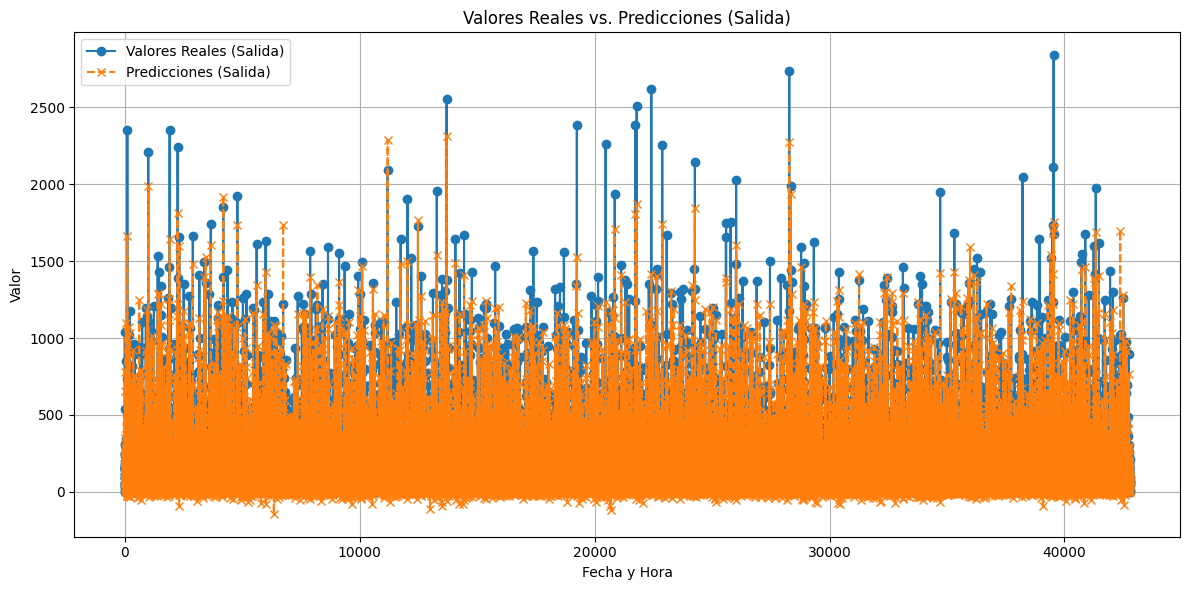

In [119]:
# Gráfico de valores reales y predicciones para la columna "salida"
plt.figure(figsize=(12, 6))
plt.plot(y_salida_test, label='Valores Reales (Salida)', marker='o')
plt.plot(y_salida_pred, label='Predicciones (Salida)', linestyle='--', marker='x')

# Configuración de etiquetas y leyenda
plt.xlabel('Fecha y Hora')
plt.ylabel('Valor')
plt.title('Valores Reales vs. Predicciones (Salida)')
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

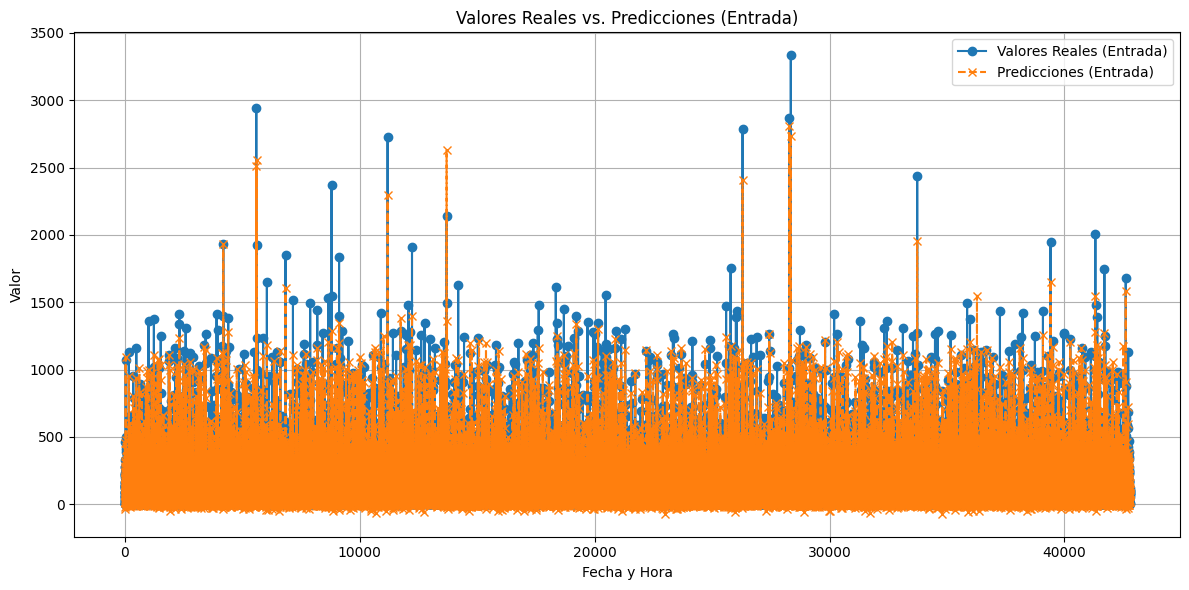

In [120]:
# Gráfico de valores reales y predicciones para la columna "salida"
plt.figure(figsize=(12, 6))
plt.plot(y_entrada_test, label='Valores Reales (Entrada)', marker='o')
plt.plot(y_entrada_pred, label='Predicciones (Entrada)', linestyle='--', marker='x')

# Configuración de etiquetas y leyenda
plt.xlabel('Fecha y Hora')
plt.ylabel('Valor')
plt.title('Valores Reales vs. Predicciones (Entrada)')
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

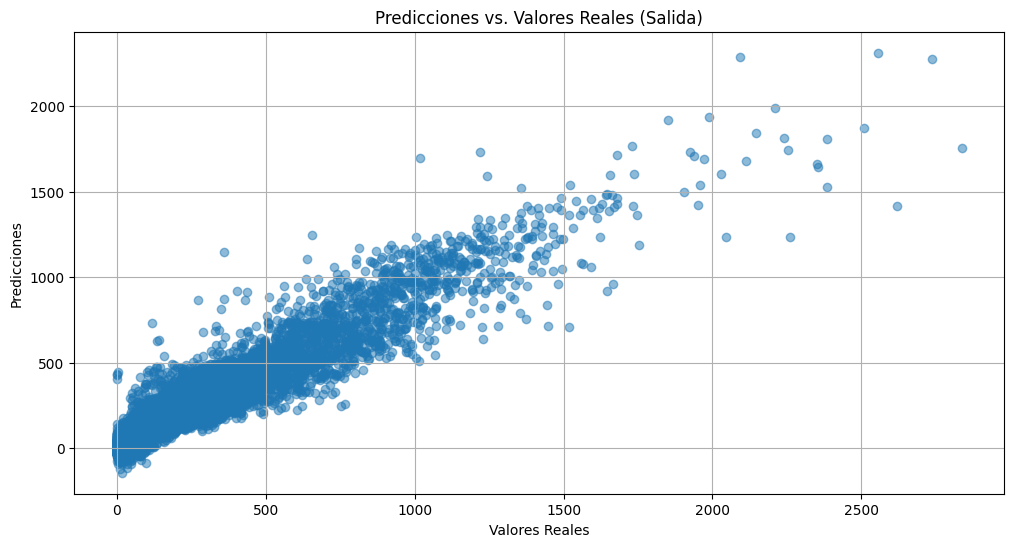

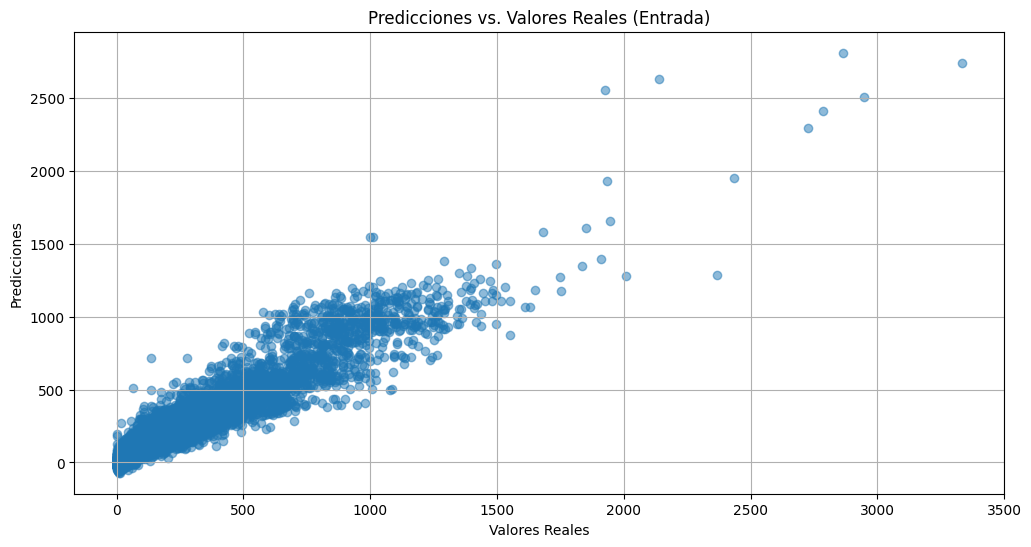

In [121]:
# Gráfico para la variable "salida"
plt.figure(figsize=(12, 6))
plt.scatter(y_salida_test, y_salida_pred, alpha=0.5)
plt.title('Predicciones vs. Valores Reales (Salida)')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid(True)
plt.show()

# Gráfico para la variable "entrada"
plt.figure(figsize=(12, 6))
plt.scatter(y_entrada_test, y_entrada_pred, alpha=0.5)
plt.title('Predicciones vs. Valores Reales (Entrada)')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid(True)
plt.show()